# Set-up

In [332]:
import wrds
import pandas as pd
import numpy as np
import os
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
script_dir = os.getcwd()

# Set the working directory to the current script's directory (which in this case is already the working directory)
os.chdir(script_dir)

print(f"Working directory is set to: {script_dir}")

# Connect to WRDS
db = wrds.Connection(wrds_username='zrsong')

# Define the start and end dates
start_date = '2009-01-01'
end_date = '2024-06-30'

Working directory is set to: /Users/zrsong/MIT Dropbox/Zirui Song/Research Projects/MPS_Interest Deductibility and Debt Contracting/4. Code
Loading library list...
Done


In [333]:
overleaf_dir = "/Users/zrsong/Dropbox (MIT)/Apps/Overleaf/Tax Incidence and Loan Contract Negotiations"

# Compustat / CRSP

In [334]:
fund_table = 'funda'

varlist = ['conm', 'tic', 'cusip','fyear', 'fyr', 'at','capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch','dltt', 'dp', 'ib', 'itcb', 
           'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'revt', 'sale', 'ebitda', 'dpc', 'oiadp', 'oibdp',
           'seq', 'sich', 'txdb', 'txdi', 'txditc', 'wcapch', 'xint', 'xlr', 'xrd', 'xsga', 'ppegt', 'xrd', 'ebit', 'aqc',
           'act', 'che', 'dltis', 'dltr', 'dvc', 'idit', 'intan', 'lct', 'dclo', 'oancf', 'pi', 'pifo', 'ppent', 'prcc_f', 'tlcf', 'txfo',
           'txdba', 'txdbca', 'txndb']

query = """SELECT gvkey, datadate, {}
           FROM comp.{}
           WHERE datafmt = 'STD'
           AND popsrc = 'D'
           AND indfmt = 'INDL'
           AND consol = 'C'
           AND fyear>=2005;""".format(", ".join(varlist), fund_table)

compa = db.raw_sql(query, date_cols=['datadate'])

del(fund_table, varlist, query)

In [335]:
# Import SIC codes from comp.company
sic_table = 'company'
query = "SELECT gvkey, sic, ipodate FROM comp.company"
sic_codes = db.raw_sql(query)

# Merge SIC codes back to compa dataframe
compa = compa.merge(sic_codes, how='left', on='gvkey')

In [336]:
# all colnames of compa
# check if sic exists
# for each gvkey fyear, keep the one with the highest at
compa = compa.sort_values(['gvkey', 'fyear', 'at'], ascending=[True, True, False])
compa = compa.drop_duplicates(subset=['gvkey', 'fyear'], keep='first')

# change ipodate to date format
compa['ipodate'] = pd.to_datetime(compa['ipodate'])

# drop if at is missing
compa = compa.dropna(subset=['at'])

# drop if xint is missing or negative
compa = compa.dropna(subset=['xint'])
compa = compa[compa['xint'] > 0]

# missing values of ebitda (due to missing dp/oiabp)
compa['ebitda'] = compa['ebitda'].fillna(compa['ebit'] + compa['dp'])
# replace ebitda = pi + xint - idit + dp if ebitda is still missing
compa['ebitda'] = compa['ebitda'].fillna(compa['pi'] + compa['xint'] - compa['idit'] + compa['dp'])
# replace ebit = pi + xint - idit if ebit is still missing
compa['ebit'] = compa['ebit'].fillna(compa['pi'] + compa['xint'] - compa['idit'])

# drop if ebitda is missing
compa = compa.dropna(subset=['ebitda'])

# define profit as EBITDA up till 2021 and EBIT from 2022 onwards (according to Michelle Hanlon's paper)
compa['profit'] = np.where(compa['fyear'] < 2022, compa['ebitda'], compa['ebit'])  

# Remove duplicate columns
compa = compa.loc[:, ~compa.columns.duplicated()]

compa['dclo'] = compa['dclo'].fillna(0)
compa['idit'] = compa['idit'].fillna(0)

In [337]:
# Debt
compa['debt'] = compa['dltt'] + compa['dlc'] - compa['dclo']

# Dividend_payer
compa['dividend_payer'] = (compa['dvc'] > 0).astype(int)

# Excess_interest 30% rule
compa['excess_interest_30'] = (compa['xint'] > compa['idit'] + 0.3 * compa['profit'].clip(lower=0)).astype(int)
# Excess_interest loss rule
compa['excess_interest_loss'] = (compa['pi'] < 0).astype(int)

# generete excess_interest_30_prev_3yr and excess_interest_loss_prev_3yr if the excess_interest_30 / excess_interest_loss == 1 at least once in the previous 3 years including the current year excess_interest_30
compa['excess_interest_30_prev_3yr_sum'] = compa.groupby('gvkey')['excess_interest_30'].shift(1) + compa.groupby('gvkey')['excess_interest_30'].shift(2)
# excess_interest_30_prev_3yr = 1 if excess_interest_30 == 1 and excess_interest_30_prev_3yr_sum >= 1
compa['excess_interest_30_prev_3yr'] = (compa['excess_interest_30'] == 1) & (compa['excess_interest_30_prev_3yr_sum'] >= 1)
compa['excess_interest_30_prev_3yr'] = compa['excess_interest_30_prev_3yr'].astype(int)

compa['excess_interest_loss_prev_3yr_sum'] = compa.groupby('gvkey')['excess_interest_loss'].shift(1) + compa.groupby('gvkey')['excess_interest_loss'].shift(2)
# excess_interest_loss_prev_3yr = 1 if excess_interest_loss == 1 and excess_interest_loss_prev_3yr_sum >= 1
compa['excess_interest_loss_prev_3yr'] = (compa['excess_interest_loss'] == 1) & (compa['excess_interest_loss_prev_3yr_sum'] >= 1)
compa['excess_interest_loss_prev_3yr'] = compa['excess_interest_loss_prev_3yr'].astype(int)

# Do the same for the previous 5 years
compa['excess_interest_30_prev_5yr_sum'] = compa.groupby('gvkey')['excess_interest_30'].shift(1) + compa.groupby('gvkey')['excess_interest_30'].shift(2) + compa.groupby('gvkey')['excess_interest_30'].shift(3) + compa.groupby('gvkey')['excess_interest_30'].shift(4)
compa['excess_interest_30_prev_5yr'] = (compa['excess_interest_30'] == 1) & (compa['excess_interest_30_prev_5yr_sum'] >= 1)
compa['excess_interest_30_prev_5yr'] = compa['excess_interest_30_prev_5yr'].astype(int)

compa['excess_interest_loss_prev_5yr_sum'] = compa.groupby('gvkey')['excess_interest_loss'].shift(1) + compa.groupby('gvkey')['excess_interest_loss'].shift(2) + compa.groupby('gvkey')['excess_interest_loss'].shift(3) + compa.groupby('gvkey')['excess_interest_loss'].shift(4)
compa['excess_interest_loss_prev_5yr'] = (compa['excess_interest_loss'] == 1) & (compa['excess_interest_loss_prev_5yr_sum'] >= 1)
compa['excess_interest_loss_prev_5yr'] = compa['excess_interest_loss_prev_5yr'].astype(int)

# replace 5yr measures with 3yr measures if 5yr measures are smaller than 3yr measures (happen when there are missing values for the previous 3-5 years)
compa['excess_interest_30_prev_5yr'] = np.where(compa['excess_interest_30_prev_5yr'] < compa['excess_interest_30_prev_3yr'], compa['excess_interest_30_prev_3yr'], compa['excess_interest_30_prev_5yr'])
compa['excess_interest_loss_prev_5yr'] = np.where(compa['excess_interest_loss_prev_5yr'] < compa['excess_interest_loss_prev_3yr'], compa['excess_interest_loss_prev_3yr'], compa['excess_interest_loss_prev_5yr'])

# generate excess_interest_30_next_1/3/5yr and excess_interest_loss_next_1/3/5yr if the excess_interest_30 / excess_interest_loss == 1 at least once in the next 1/3/5 years including the current year excess_interest_30
compa['excess_interest_30_next_1yr_sum'] = compa.groupby('gvkey')['excess_interest_30'].shift(-1)
compa['excess_interest_30_next_1yr'] = compa['excess_interest_30_next_1yr_sum'] == 1
compa['excess_interest_30_next_1yr'] = compa['excess_interest_30_next_1yr'].astype(int)

compa['excess_interest_loss_next_1yr_sum'] = compa.groupby('gvkey')['excess_interest_loss'].shift(-1)
compa['excess_interest_loss_next_1yr'] = compa['excess_interest_loss_next_1yr_sum'] == 1
compa['excess_interest_loss_next_1yr'] = compa['excess_interest_loss_next_1yr'].astype(int)

compa['excess_interest_30_next_3yr_sum'] = compa.groupby('gvkey')['excess_interest_30'].shift(-2) + compa.groupby('gvkey')['excess_interest_30'].shift(-3)
compa['excess_interest_30_next_3yr'] = (compa['excess_interest_30_next_1yr'] == 1) & compa['excess_interest_30_next_3yr_sum'] >= 1
compa['excess_interest_30_next_3yr'] = compa['excess_interest_30_next_3yr'].astype(int)

compa['excess_interest_loss_next_3yr_sum'] = compa.groupby('gvkey')['excess_interest_loss'].shift(-2) + compa.groupby('gvkey')['excess_interest_loss'].shift(-3)
compa['excess_interest_loss_next_3yr'] = (compa['excess_interest_loss_next_1yr'] == 1) & (compa['excess_interest_loss_next_3yr_sum'] >= 1)
compa['excess_interest_loss_next_3yr'] = compa['excess_interest_loss_next_3yr'].astype(int)

compa['excess_interest_30_next_5yr_sum'] = compa.groupby('gvkey')['excess_interest_30'].shift(-2) + compa.groupby('gvkey')['excess_interest_30'].shift(-3) + compa.groupby('gvkey')['excess_interest_30'].shift(-4) + compa.groupby('gvkey')['excess_interest_30'].shift(-5)
compa['excess_interest_30_next_5yr'] = (compa['excess_interest_30_next_1yr'] == 1) & (compa['excess_interest_30_next_5yr_sum'] >= 1)
compa['excess_interest_30_next_5yr'] = compa['excess_interest_30_next_5yr'].astype(int)

compa['excess_interest_loss_next_5yr_sum'] = compa.groupby('gvkey')['excess_interest_loss'].shift(-2) + compa.groupby('gvkey')['excess_interest_loss'].shift(-3) + compa.groupby('gvkey')['excess_interest_loss'].shift(-4) + compa.groupby('gvkey')['excess_interest_loss'].shift(-5)
compa['excess_interest_loss_next_5yr'] = (compa['excess_interest_loss_next_1yr'] == 1) & (compa['excess_interest_loss_next_5yr_sum'] >= 1)
compa['excess_interest_loss_next_5yr'] = compa['excess_interest_loss_next_5yr'].astype(int)

# replace 5yr measures with 3yr measures if 5yr measures are smaller than 3yr measures (happen when there are missing values for the next 3-5 years)
compa['excess_interest_30_next_5yr'] = np.where(compa['excess_interest_30_next_5yr'] < compa['excess_interest_30_next_3yr'], compa['excess_interest_30_next_3yr'], compa['excess_interest_30_next_5yr'])
compa['excess_interest_loss_next_5yr'] = np.where(compa['excess_interest_loss_next_5yr'] < compa['excess_interest_loss_next_3yr'], compa['excess_interest_loss_next_3yr'], compa['excess_interest_loss_next_5yr'])

# Financial deficit
compa['financial_deficit'] = (compa['oancf'] - compa['capx'] - compa['dvc'] < 0).astype(int)

# Immediate_depletion
compa['immediate_depletion'] = (compa['che'] + compa['oancf'] - compa['capx'] - compa['dvc'] < 0).astype(int)

# Interest expense loss rule
compa['interest_expense_loss_rule'] = np.where(
    (compa['pi'] + compa['xint']) <= 0,
    compa['xint'],
    np.where(
        compa['xint'] > (compa['pi'] + compa['xint']),
        compa['xint'] - (compa['pi'] + compa['xint']),
        0
    )
)

# Interest expense 30% rule
compa['interest_expense_30_rule'] = compa['xint'] - compa['interest_expense_loss_rule'] - (compa['idit'] +  0.3 * compa['profit'].clip(lower=0))
# clip lower bound to 0
compa['interest_expense_30_rule'] = compa['interest_expense_30_rule'].clip(lower=0)

# Interest expense not excess
compa['interest_expense_not_excess'] = compa['xint'] - compa['interest_expense_loss_rule'] - compa['interest_expense_30_rule']

# Interest expense total excess
compa['interest_expense_total_excess'] = compa['interest_expense_loss_rule'] + compa['interest_expense_30_rule']
# clip lower bound to 0
compa['interest_expense_total_excess'] = compa['interest_expense_total_excess'].clip(lower=0)

# Investment
compa['investment'] = compa['aqc'] + compa['capx'] + compa['xrd']

# Loss before interest expense
compa['loss_before_interest_expense'] = ((compa['pi'] + compa['idit']) < 0).astype(int)

# Market to book
compa['market_to_book'] = (compa['debt'] + compa['pstk'] + (compa['prcc_f'] * compa['csho'])) / compa['at']

# MNC (indicator = 1 if pifo or txfo not missing or zero)
compa['mnc'] = ((compa['pifo'] != 0) | (compa['txfo'] != 0)).astype(int)

# Net interest
compa['net_interest'] = compa['xint'] - compa['idit']

# NOL 
compa['nol'] = (compa['tlcf'] > 0).astype(int)

# Sales growth
compa['sales_growth'] = (compa['sale'] - compa['sale'].shift(1)) / compa['sale'].shift(1)
# change sales growth to 0 if inf
compa['sales_growth'] = compa['sales_growth'].replace([np.inf, -np.inf], 0)
# clip sales growth to -1 and 1
compa['sales_growth'] = compa['sales_growth'].clip(-1, 1)

# Z-score
compa['z_score'] = (3.3 * compa['pi'] + 1.0 * compa['sale'] + 1.4 * compa['re'] + 1.2 * (compa['act'] - compa['lct'])) / compa['at']

# Delta_DCF
compa['delta_dcf'] = compa['dltis'] - compa['dltr']

# calculate the interest coverage ratio
compa['interest_expense_by_ebitda'] = (compa['xint'] - compa['idit']) / compa['profit']
# describe the interest coverage ratio
compa['interest_expense_by_ebitda'].describe()

# generate next year's interest coverage ratio
compa['interest_expense_by_ebitda_next_1yr'] = compa.groupby('gvkey')['interest_expense_by_ebitda'].shift(-1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [338]:
# Define the variables to be imported
crsp_vars = ['cusip', 'permco', 'permno', 'date', 'ret', 'vol', 'shrout', 'prc']

# Define the query to get the annual returns of North American firms
crsp_query = f"""
    SELECT {', '.join(crsp_vars)}
    FROM crsp.msf
    WHERE date >= '{start_date}' AND date <= '{end_date}'
"""

# Execute the query and fetch the data
crspm = db.raw_sql(crsp_query, date_cols=['date'])

# Display the first few rows of the dataframe
print(crspm.head())

# header information from the CRSP file
crsp_hdr_query = """
    SELECT *
    FROM crsp.dsfhdr
"""

# Execute the query and fetch the data
crsp_hdr = db.raw_sql(crsp_hdr_query, date_cols=['date'])

# Display the first few rows of the dataframe
print(crsp_hdr.head())

      cusip  permco  permno       date       ret      vol   shrout     prc
0  36720410    7953   10001 2009-01-30  0.034140    695.0   4297.0   8.502
1  05978R10    7954   10002 2009-01-30 -0.399052  10824.0  17555.0   8.870
2  00103110    7975   10025 2009-01-30 -0.184300   4000.0   6774.0  14.340
3  46603210    7976   10026 2009-01-30 -0.027035  20189.0  18342.0  34.910
4  29402E10    7978   10028 2009-01-30 -0.191176    816.0   9834.0  -1.375
   permno  permco  hshrcd  dlstcd    hcusip htick  \
0   10000    7952      10     560  68391610  None   
1   10001    7953      11     233  36720410  None   
2   10002    7954      11     231  05978R10  None   
3   10003    7957      11     231  39031810  None   
4   10004    7960      10     575  18906310  None   

                         hcomnam htsymbol  hnaics hprimexc  ...      begvol  \
0      OPTIMUM MANUFACTURING INC    OMFGA    None        Q  ...  1986-01-07   
1                GAS NATURAL INC     EGAS  221210        A  ...  1986-01-

In [339]:
# merge crspm and crsp_hdr with permno
crspm = crspm.merge(crsp_hdr[['permno', 'dlstcd']], on='permno', how='left')

# sort by permno date
crspm = crspm.sort_values(['permno', 'date'])

# Aggregate the data by permno and year and calculate the buy and hold return over the year as well as the volatility
crspm['year'] = crspm['date'].dt.year

# Display the first few rows of the dataframe
print(crspm.head())

          cusip  permco  permno       date       ret    vol  shrout    prc  \
0      36720410    7953   10001 2009-01-30  0.034140  695.0  4297.0  8.502   
6909   36720410    7953   10001 2009-02-27  0.056222  412.0  4297.0  8.940   
13790  36720410    7953   10001 2009-03-31 -0.080537  979.0  4300.0  8.180   
20635  36720410    7953   10001 2009-04-30  0.044621  828.0  4300.0  8.500   
27448  36720410    7953   10001 2009-05-29  0.002941  825.0  4354.0  8.480   

       dlstcd  year  
0         233  2009  
6909      233  2009  
13790     233  2009  
20635     233  2009  
27448     233  2009  


In [340]:
std_ret = crspm.groupby(['permno', 'year'])['ret'].std().reset_index()
buy_and_hold_return = crspm.groupby(['permno', 'year'])['ret'].apply(lambda x: (1 + x).prod() - 1).reset_index()
# merge the buy and hold return and the volatility to the crspm dataframe
crspm = crspm.merge(buy_and_hold_return, on=['permno', 'year'], suffixes=('', '_buy_and_hold'))
crspm = crspm.merge(std_ret, on=['permno', 'year'], suffixes=('', '_vol'))

# aggregate to permno and year level (keep ret_buy_and_hold and ret_vol and dlstcd)
crspa = crspm.groupby(['permno', 'year']).agg({
    'ret_buy_and_hold': 'first',
    'ret_vol': 'first',
    'dlstcd': 'first'
}).reset_index()

In [341]:
# Compustat/CRSP Link Table
ccm_query = """
    SELECT gvkey, lpermno, linktype, linkprim, linkdt, linkenddt
    FROM crsp.ccmxpf_linktable
"""

# Execute the query and fetch the data
ccm = db.raw_sql(ccm_query, date_cols=['linkdt', 'linkenddt'])

# Display the first few rows of the dataframe
print(ccm.head())

# merge crspa and ccm
crspac = crspa.merge(ccm, left_on='permno', right_on='lpermno', how='left')

# keep only the rows where the link date is before the year and the link end date is after the year
# change linkenddt to 2024-12-31 if it is NaT
crspac['linkenddt'] = crspac['linkenddt'].fillna(pd.Timestamp('2024-12-31'))
crspac = crspac[(crspac['year'] >= crspac['linkdt'].dt.year) & (crspac['year'] <= crspac['linkenddt'].dt.year)]

    gvkey  lpermno linktype linkprim     linkdt  linkenddt
0  001000      NaN       NU        C 1961-01-01 1970-09-29
1  001000      NaN       NU        P 1970-09-30 1970-11-12
2  001000  25881.0       LU        P 1970-11-13 1978-06-30
3  001001      NaN       NU        C 1978-01-01 1983-09-19
4  001001  10015.0       LU        P 1983-09-20 1986-07-31


In [342]:
# merge crspac with compa on gvkey (keep everything)
comp_crspa_merged = compa.merge(crspac, left_on=['gvkey', 'fyear'], right_on=['gvkey', 'year'], how='inner')
# drop year
comp_crspa_merged = comp_crspa_merged.drop(columns='year')

In [343]:
# change gvkey to int
comp_crspa_merged['gvkey'] = comp_crspa_merged['gvkey'].astype(int)

# drop if sale < 25 million throughout the sample period (to match the sample in Michelle Hanlon's paper)
# generate largest sale for each gvkey
compa['largest_sale'] = compa.groupby('gvkey')['sale'].transform('max')
# drop if sale < 25 million
compa = compa[compa['largest_sale'] >= 25]

# output csv. format
comp_crspa_merged.to_csv("../3. Data/Processed/comp_crspa_merged.csv", index=False)

In [344]:
# read in the processed data
comp_crspa_merged = pd.read_csv("../3. Data/Processed/comp_crspa_merged.csv")

## Quarterly Compustat

In [345]:
# # Quarterly Compustat data
# fund_table = 'fundq'
# varlist = ['gvkey', 'conm', 'tic', 'cusip','fyearq', 'fqtr', 'fyr', 'atq','capxy', 'ceqq', 'cogsq', 
#            'cshoq', 'dlcq', 'dlcchy','dlttq', 'dpq', 'ibq', 'itccy', 'fic', 'pstkrq',
#            'ltq', 'mibq', 'niq', 'prstkccy', 'pstkq', 'req', 'revtq', 'saleq',
#            'seqq', 'txdbq', 'txdiq', 'txditcq', 'wcapchy', 'xinty', 'xrdq', 'xrdy', 'xsgaq',
#            'mkvaltq', 'epspxq', 'epsfxq', 'ajexq', 'prccq', 'oancfy', 'ivncfy', 'rdq', 'ppegtq', 'ppentq']
# # Join the list into a comma-separated string
# varlist_str = ", ".join(varlist)
# # use the varlist above to query quarterly compustat data (don't use join(varlist) as it will return a string)
# query = f"""
#     SELECT {varlist_str}
#     FROM comp_na_daily_all.{fund_table}
#     WHERE datadate >= '{start_date}' AND datadate <= '{end_date}'
# """
# compq = db.raw_sql(query)
# # How to deal with duplicates? Keep last available entry (datadate)
# compq.dropna(subset=['fyearq', 'fqtr'], inplace=True)
# compq.sort_values(['gvkey','fyearq', 'fqtr', 'atq'], inplace=True)
# compq = compq[~compq.duplicated(['gvkey', 'fyearq', 'fqtr'], keep='last')]
# duplicate_columns = compq.columns[compq.columns.duplicated()]
# print("Duplicate columns:", duplicate_columns)
# # Calculating BE
# # Shareholder Equity
# compq['se'] = compq['seqq']
# # Uses Common Equity (ceq) + Preferred Stock (pstk) if SEQ is missing:
# compq['se'] = compq['se'].fillna(compq['ceqq'] + compq['pstkq'])
# # Uses Total Assets (at) - Liabilities (lt) + Minority Interest (mib, if available), if others are missing
# compq['se'] = compq['se'].fillna(compq['atq'] - compq['ltq'] + compq['mibq'].fillna(0))
# # Preferred Stock
# # Preferred Stock (Redemption Value)
# compq['ps'] = compq['pstkrq']
# # Uses Preferred Stock (Liquidating Value (pstkl)) if Preferred Stock (Redemption Value) is missing (pstkl doesnt' exist for quarterly data)
# # compq['ps'] = compq['ps'].fillna(compq['pstkl'])
# # Uses Preferred Stock (Carrying Value (pstk)) if others are missing
# compq['ps'] = compq['ps'].fillna(compq['pstkq'])
# # Deferred Taxes
# # Uses Deferred Taxes and Investment Tax Credit (txditc)
# compq['dt'] = compq['txditcq']
# # This was Novy-Marx old legacy code. We drop this part to be in accordance with Ken French.
# # Uses Deferred Taxes and Investment Tax Credit(txdb) + Investment Tax Credit (Balance Sheet) (itcb) if txditc is missing (itcb (Investment Tax Credit (Balance Sheet)) doesn't exist for quarterly data)
# compq['dt'] = compq['dt'].fillna(compq['txdbq'].fillna(0))
# # If all measures are missing, set to missing
# compq.loc[pd.isnull(compq['txditcq']) & pd.isnull(compq['txdbq']), 'dt'] = np.nan
# # Book Equity
# # Book Equity (BE) = Share Equity (se) - Prefered Stocks (ps) + Deferred Taxes (dt)
# compq['be'] = (compq['se']  # shareholder equity must be available, otherwise BE is missing
#                - compq['ps']  # preferred stock must be available, otherwise BE is missing
#                + compq['dt'].fillna(0))  # add deferred taxes if available
#                #- compa['prba'].fillna(0))  # subtract postretirement benefit assets if available
# # COST = COGS + XSGA + XINT 
# compq['cost'] = compq[['cogsq', 'xsgaq', 'xinty']].sum(axis=1, skipna=True)
# compq.loc[compq[['cogsq', 'xsgaq', 'xinty']].isnull().all(axis=1), 'cost'] = np.nan
# # OP = SALE - COST    
# compq['op'] = compq['saleq']-compq['cost']
# # output csv. format
# compq.to_csv("../Data/Raw/compustat_quarterly.csv", index=False)

# Ratings Data

In [346]:
ciq_ratings = pd.read_csv("../3. Data/Raw/ciq_ratings.csv")
# keep gvkey rating_date ratingsymbol
ciq_ratings = ciq_ratings[['gvkey', 'ratingdate', 'currentratingsymbol']]
# sort by gvkey rating_date
ciq_ratings = ciq_ratings.sort_values(['gvkey', 'ratingdate'])
# drop duplicates
ciq_ratings = ciq_ratings.drop_duplicates(subset=['gvkey', 'ratingdate'], keep='last')
# generate rating_year
ciq_ratings['rating_year'] = pd.to_datetime(ciq_ratings['ratingdate']).dt.year
# keep the latest rating for each year
ciq_ratings = ciq_ratings.sort_values(['gvkey', 'rating_year', 'ratingdate'])
ciq_ratings = ciq_ratings.drop_duplicates(subset=['gvkey', 'rating_year'], keep='last')

# Create full grid of IDs and years
all_ids = ciq_ratings['gvkey'].unique()
all_years = range(2010, 2024)
full_index = pd.MultiIndex.from_product([all_ids, all_years], names=['gvkey', 'rating_year'])

# Reindex the DataFrame
balanced_ratings = ciq_ratings.set_index(['gvkey', 'rating_year']).reindex(full_index).reset_index()

# Fill missing values with the most recent previous rating
balanced_ratings['currentratingsymbol'] = balanced_ratings.groupby('gvkey')['currentratingsymbol'].ffill()

print(balanced_ratings)

/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_19460/477045535.py:1: DtypeWarning: Columns (15,47) have mixed types. Specify dtype option on import or set low_memory=False.
  ciq_ratings = pd.read_csv("../3. Data/Raw/ciq_ratings.csv")


        gvkey  rating_year  ratingdate currentratingsymbol
0      1004.0         2010         NaN                 NaN
1      1004.0         2011         NaN                 NaN
2      1004.0         2012         NaN                 NaN
3      1004.0         2013         NaN                 NaN
4      1004.0         2014         NaN                 NaN
...       ...          ...         ...                 ...
85157     NaN         2019  2019-12-30                 NaN
85158     NaN         2020  2020-12-31                 NaN
85159     NaN         2021  2021-12-30                 NaN
85160     NaN         2022  2022-12-30                 NaN
85161     NaN         2023  2023-12-29                 NaN

[85162 rows x 4 columns]


# Dealscan

In [347]:
# Query the dealscan syndicated loan data
#query = f"""
#    SELECT *
#    FROM tr_dealscan.dealscan
#    WHERE deal_active_date >= '{start_date}' AND deal_active_date <= '{end_date}'
#"""

# Execute the query and fetch the data
#dealscan_data = db.raw_sql(query)
# Save the data to a CSV file
#dealscan_data.to_csv('../Data/Raw/dealscan_data.csv', index=False)

In [348]:
# import dealscan data 
dealscan_data = pd.read_csv("../3. Data/Raw/dealscan_data.csv")

/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_19460/4219223696.py:2: DtypeWarning: Columns (26,42,46,50,65,85,103,106,107,108,109,112,113,122,127,130,138,139,140,142,146,150,151,152,155,156,157,158,159,160,161,162,163,164,200,202) have mixed types. Specify dtype option on import or set low_memory=False.
  dealscan_data = pd.read_csv("../3. Data/Raw/dealscan_data.csv")


In [349]:
# Convert deal_active_date to datetime if it's not already
dealscan_data['deal_active_date'] = pd.to_datetime(dealscan_data['deal_active_date'])

# Filter the dataframe
dealscan_data = dealscan_data[dealscan_data['deal_active_date'] >= '2010-01-01']

# keep only county == "United States"
dealscan_data = dealscan_data[dealscan_data['country'] == 'United States']

# generate leveraged = 1 if the text "Leveraged" appears in market_segment
dealscan_data['leveraged'] = dealscan_data['market_segment'].str.contains("Leveraged", case=False, na=False).astype(int)

# generate year from deal_active_date
dealscan_data['year'] = dealscan_data['deal_active_date'].dt.year

## Amendments (Rate Increasing/Decreasing Calculation) and Relationship 

In [350]:
# sort by gvkey and year and lpc_deal_id lpc_tranche_id lender_id
dealscan_data = dealscan_data.sort_values(['lpc_deal_id', 'lpc_tranche_id', 'lender_id'])
# put lpc_deal_id, lpc_tranche_id, lender_id in front of the dataframe
ds_relationship = dealscan_data[['lpc_deal_id', 'deal_active_date', 'tranche_active_date', 'lpc_tranche_id', 'borrower_name', 'borrower_id', 'lender_parent_name', 'lender_parent_id', 'lender_id', 'lender_name', 'primary_role', 'lead_left', 'lead_arranger']]
# keep only when lender_name = lead_left
ds_relationship = ds_relationship[ds_relationship['lender_name'] == ds_relationship['lead_left']]

# collapse by lender_parent_id and borrower_id and lpc_deal_id
ds_relationship_final = ds_relationship.groupby(['lender_parent_id', 'borrower_id', 'lpc_deal_id']).agg({
    'deal_active_date': 'first',
    'lender_parent_name': 'first',
    'lender_name': 'first',
    'borrower_name': 'first',
}).reset_index()


In [351]:
# sort by lender_parent_id and borrower_id and deal_active_date
ds_relationship_final = ds_relationship_final.sort_values(['lender_parent_id', 'borrower_id', 'deal_active_date'])
# for each lender_parent_id and borrower_id, gen prev_rel_years = difference between current deal_active_date and previous deal_active_date
ds_relationship_final['prev_rel_years'] = ds_relationship_final.groupby(['lender_parent_id', 'borrower_id'])['deal_active_date'].diff().dt.days / 365
ds_relationship_final['relationship'] = (ds_relationship_final['prev_rel_years'] <= 5).astype(int)
# generate reputation = 1 if lender_parent_name is "JP Morgan", "BofA Securities", "Wells Fargo & Co"
ds_relationship_final['reputation'] = ds_relationship_final['lender_parent_name'].isin(['JP Morgan', 'BofA Securities', 'Wells Fargo & Co']).astype(int)

ds_relationship_to_merge = ds_relationship_final.groupby(['lpc_deal_id']).agg({
    'relationship': 'max',
    'reputation': 'max',
})

In [352]:
# collapse down to lpc_deal_id and keep lpc_tranche_id, tranche_active_date, year, tranche_active_date, borrower_name, borrower_id, margin_bps, tranche_o_a, tranche_type
ds_tranche_level = dealscan_data.groupby('lpc_tranche_id').agg({
    'lpc_deal_id': 'first',
    'tranche_active_date': 'first',
    'borrower_name': 'first',
    'borrower_id': 'first',
    'margin_bps': 'first',
    'tranche_o_a': 'first',
    'tranche_type': 'first',
}).reset_index()

# sort by borrower_id, year, lpc_deal_id, lpc_tranche_id
ds_tranche_level = ds_tranche_level.sort_values(['borrower_id', 'lpc_deal_id', 'tranche_active_date'])
# generate ds_delta_margin = difference between current margin_bps and previous margin_bps
ds_tranche_level['delta_margin'] = ds_tranche_level.groupby(['tranche_type', 'lpc_deal_id'])['margin_bps'].diff()
# generate increase_margin = 1 if delta_margin > 0
ds_tranche_level['increase_margin'] = (ds_tranche_level['delta_margin'] > 0).astype(int)
ds_tranche_level['decrease_margin'] = (ds_tranche_level['delta_margin'] < 0).astype(int)
ds_delta_margin = ds_tranche_level[['lpc_tranche_id', 'delta_margin', 'increase_margin', 'decrease_margin']]
# drop if delta_margin is missing
ds_delta_margin = ds_delta_margin.dropna(subset=['delta_margin'])

## Merge with Compustat/CRSP

In [353]:
dealscan_new_legacy_link = pd.read_excel('../3. Data/Raw/WRDS_to_LoanConnector_IDs.xlsx')

# Rename columns to lpc_deal_id, packageid, lpc_tranche_id, facilityid
dealscan_new_legacy_link.columns = ['lpc_deal_id', 'packageid', 'lpc_tranche_id', 'facilityid']

# Identify duplicates in the combination of 'lpc_deal_id' and 'lpc_tranche_id'
dealscan_new_legacy_link['dup'] = dealscan_new_legacy_link.duplicated(subset=['lpc_deal_id', 'lpc_tranche_id'], keep=False).astype(int)

# Drop rows where duplicates exist (i.e., 'dup' != 0)
dealscan_new_legacy_link = dealscan_new_legacy_link[dealscan_new_legacy_link['dup'] == 0]

# Drop the 'dup' column (no longer needed)
dealscan_new_legacy_link = dealscan_new_legacy_link.drop(columns=['dup'])

# merge with dealscan_data on lpc_deal_id and lpc_tranche_id
dealscan_new_old_merged = dealscan_data.merge(dealscan_new_legacy_link, on=['lpc_deal_id', 'lpc_tranche_id'], how='inner')

In [354]:
dealscan_compustat_link = pd.read_excel('../3. Data/Raw/Dealscan-Compustat_Linking_Database012024.xlsx', sheet_name = 'links')

dealscan_merged_till2020 = dealscan_new_old_merged.merge(dealscan_compustat_link, on='facilityid', how='inner')

dealscan_compustat_link_2020onward = pd.read_csv('../3. Data/Raw/DS_linktable_extension_update.csv')

dealscan_merged_2020onward = dealscan_data.merge(dealscan_compustat_link_2020onward, on='lpc_deal_id', how='inner')

# Add a column to indicate the source
dealscan_merged_till2020['source'] = 'till2020'
dealscan_merged_2020onward['source'] = '2020onward'

dealscan_merged = pd.concat([dealscan_merged_till2020, dealscan_merged_2020onward], ignore_index=True)

In [355]:
# merge gvkey with compustat annual data for now 
dealscan_merged['fyear'] = dealscan_merged['year'] - 1 # use the previous fiscal year financials 

dealscan_comp_crspa_merged = dealscan_merged.merge(comp_crspa_merged, on=['gvkey', 'fyear'], how='inner')

# Finalize DS-Compa Merged Data

In [356]:
# order by lpc_deal_id facilityid lpc_tranche_id packageid and sort by them
dealscan_comp_crspa_merged = dealscan_comp_crspa_merged.sort_values(['lpc_deal_id', 'facilityid', 'lpc_tranche_id', 'packageid'])
dealscan_comp_crspa_merged = dealscan_comp_crspa_merged.reset_index(drop=True)

# put lpc_deal_id facilityid lpc_tranche_id packageid tranchetype and deal_active_date in the first columns
dealscan_comp_crspa_merged = dealscan_comp_crspa_merged[['lpc_deal_id', 'facilityid', 'lpc_tranche_id', 'packageid', 'tranche_type', 'deal_active_date'] + 
                                              [col for col in dealscan_comp_crspa_merged.columns if col not in ['lpc_deal_id', 'facilityid', 'lpc_tranche_id', 'packageid', 'tranchetype', 'deal_active_date']]]

# drop duplicated columns
dealscan_comp_crspa_merged = dealscan_comp_crspa_merged.loc[:, ~dealscan_comp_crspa_merged.columns.duplicated()]
# change tranche_active_date and tranche_maturity date to datetime
dealscan_comp_crspa_merged['tranche_active_date'] = pd.to_datetime(dealscan_comp_crspa_merged['tranche_active_date'])
dealscan_comp_crspa_merged['tranche_maturity_date'] = pd.to_datetime(dealscan_comp_crspa_merged['tranche_maturity_date'])

# collapse by lpc_tranche_id and keep only the first entry 
tranche_level_ds_compa = dealscan_comp_crspa_merged.groupby(['lpc_tranche_id']).agg({
    'number_of_lenders': 'first',
    'number_of_lead_arrangers': 'first',
    'tranche_type': 'first',
    'tranche_o_a': 'first',
    'lpc_deal_id': 'first',
    'packageid': 'first',
    'facilityid': 'first',
    'deal_permid': 'first',
    'deal_active_date': 'min',
    'tranche_active_date': 'min',
    'tranche_maturity_date': 'min',
    'year': 'first',
    'gvkey': 'first',
    'borrower_name': 'first',
    'borrower_id': 'first',
    'lender_parent_name': 'first',
    'lender_parent_id': 'first',
    'lender_name': 'first',
    'lender_id': 'first',
    'state_province': 'first',
    'country': 'first',
    'zip': 'first',
    'city': 'first',
    'sic_code': 'first',
    'sponsor': 'first',
    'lead_arranger': 'first',
    'deal_amount': 'first',
    'deal_amount_converted': 'first',
    'deal_purpose': 'first',
    'deal_amended': 'first',
    'market_segment': 'first',
    'seniority_type': 'first',
    'secured': 'first',
    'margin_bps': 'first',
    'leveraged': 'first',
    'fyear': 'first',
    'covenants': 'first', 
    'all_covenants_financial': 'first',
    'performance_pricing': 'first',
    'excess_cf_sweep': 'first',
    'asset_sales_sweep': 'first',
    'debt_issue_sweep': 'first',
    'equity_issue_sweep': 'first',
    'insurance_proceeds_sweep': 'first',
    'interest_expense_by_ebitda': 'first',
    'interest_expense_by_ebitda_next_1yr': 'first',
    'xint': 'first',
    'ebitda': 'first',
    'ebit': 'first',
    'profit': 'first',
    'at': 'first',
    'capx': 'first',
    'che': 'first',
    'oancf': 'first',
    'debt': 'first',
    'dlstcd': 'first',
    'dvc': 'first',
    'dividend_payer': 'first',
    'pi': 'first',
    'dp': 'first',
    'excess_interest_30': 'first',
    'excess_interest_loss': 'first',
    'excess_interest_30_prev_3yr': 'first',
    'excess_interest_loss_prev_3yr': 'first',
    'excess_interest_30_prev_5yr': 'first',
    'excess_interest_loss_prev_5yr': 'first',
    'excess_interest_30_next_1yr': 'first',
    'excess_interest_loss_next_1yr': 'first',
    'excess_interest_30_next_3yr': 'first',
    'excess_interest_loss_next_3yr': 'first',
    'excess_interest_30_next_5yr': 'first',
    'excess_interest_loss_next_5yr': 'first',
    'financial_deficit': 'first',
    'immediate_depletion': 'first',
    'intan': 'first',
    'interest_expense_30_rule': 'first',
    'interest_expense_loss_rule': 'first',
    'interest_expense_not_excess': 'first',
    'interest_expense_total_excess': 'first',
    'idit': 'first',
    'investment': 'first',
    'loss_before_interest_expense': 'first',
    'market_to_book': 'first',
    'mnc': 'first',
    'net_interest': 'first',
    'nol': 'first',
    'ppent': 'first',
    'xrd': 'first',
    'sale': 'first',
    'sales_growth': 'first',
    'ret_buy_and_hold': 'first',
    'ret_vol': 'first',
    'z_score': 'first',
    'delta_dcf': 'first',
    'ipodate': 'first',
}).reset_index()

# drop if year < 2014 or year = 2024
#tranche_level_ds_compa = tranche_level_ds_compa[(tranche_level_ds_compa['year'] >= 2014) & (tranche_level_ds_compa['year'] < 2024)]

## Amendment Pricing Analysis

In [357]:
# post = 1 if year > 2017 (2017 as hold-out period)
tranche_level_ds_compa.loc[:, 'post'] = (tranche_level_ds_compa['year'] > 2017).astype(int)

In [358]:
# NEW from Dec 18th (Merge with Amendments Info)
# Merge with amendments info
delta_margin = tranche_level_ds_compa.merge(ds_delta_margin, how='inner', on=['lpc_tranche_id'])

   excess_interest_loss  post  delta_margin  increase_margin  decrease_margin
0                     0     0     -1.943826         0.183537         0.260289
1                     0     1      3.348083         0.227139         0.247788
2                     1     0      0.169903         0.208738         0.233010
3                     1     1      1.388433         0.216418         0.186567


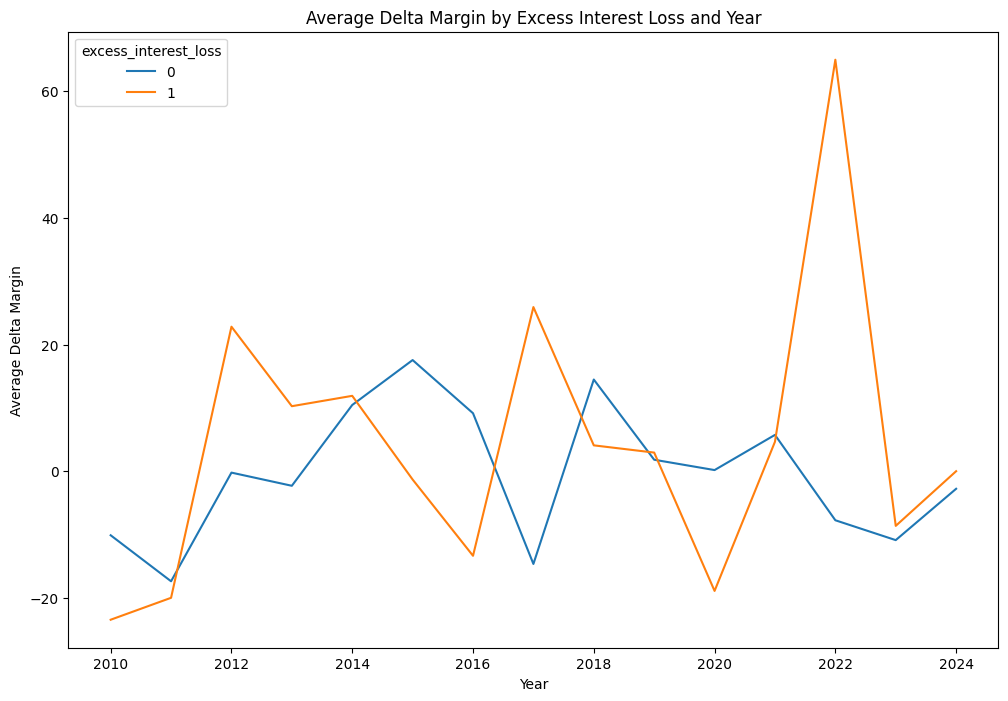

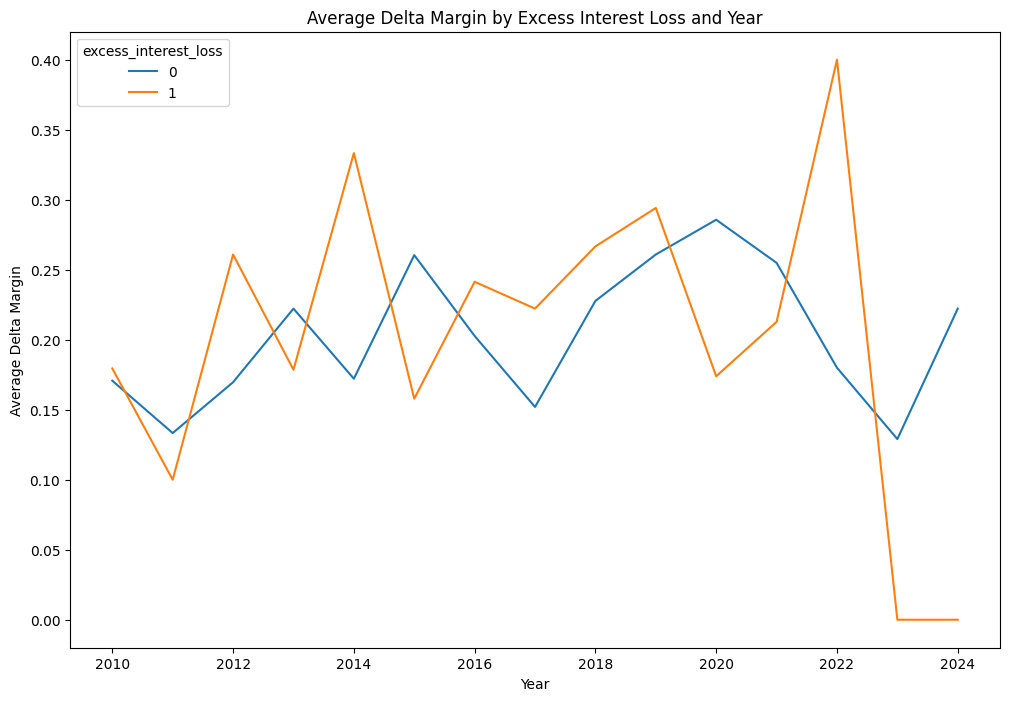

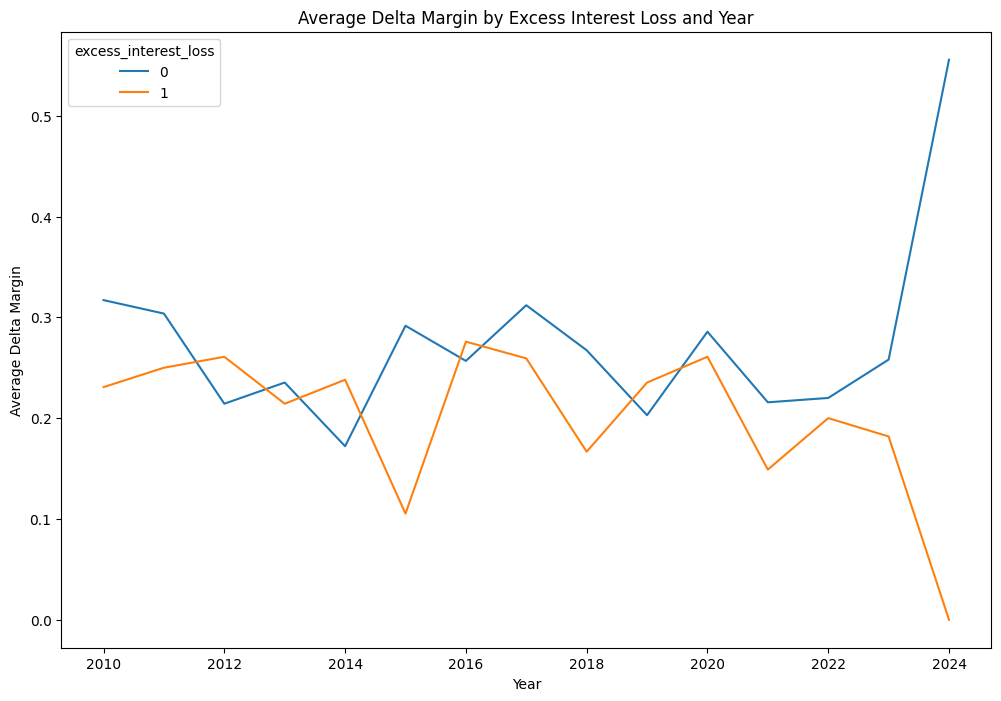

In [359]:
# collapse data down to excess_interest_loss and year level and keep average delta_margin
# keep if delta_margin != 0
#delta_margin = delta_margin[delta_margin['delta_margin'] != 0]
treat_delta_margin = delta_margin.groupby(['excess_interest_loss', 'year']).agg({
    'delta_margin': 'mean',
    'increase_margin': 'mean',
    'decrease_margin': 'mean',
}).reset_index()

# collapse data down to excess_interest_loss and year level and keep average excess_interest_30
treat_post_delta_margin = delta_margin.groupby(['excess_interest_loss', 'post']).agg({
    'delta_margin': 'mean',
    'increase_margin': 'mean',
    'decrease_margin': 'mean',
}).reset_index()


# print the average delta_margin by excess_interest_loss and post
print(treat_post_delta_margin)

# plot the average delta_margin by excess_interest_loss and year
plt.figure(figsize=(12, 8))
sns.lineplot(data=treat_delta_margin, x='year', y='delta_margin', hue='excess_interest_loss')
plt.title('Average Delta Margin by Excess Interest Loss and Year')
plt.xlabel('Year')
plt.ylabel('Average Delta Margin')
plt.savefig(f"{overleaf_dir}/average_delta_margin_excess_interest_loss_year.png")

# plot the average delta_margin by excess_interest_loss and year
plt.figure(figsize=(12, 8))
sns.lineplot(data=treat_delta_margin, x='year', y='increase_margin', hue='excess_interest_loss')
plt.title('Average Delta Margin by Excess Interest Loss and Year')
plt.xlabel('Year')
plt.ylabel('Average Delta Margin')
plt.savefig(f"{overleaf_dir}/average_delta_margin_excess_interest_loss_year.png")

# plot the average delta_margin by excess_interest_loss and year
plt.figure(figsize=(12, 8))
sns.lineplot(data=treat_delta_margin, x='year', y='decrease_margin', hue='excess_interest_loss')
plt.title('Average Delta Margin by Excess Interest Loss and Year')
plt.xlabel('Year')
plt.ylabel('Average Delta Margin')
plt.savefig(f"{overleaf_dir}/average_delta_margin_excess_interest_loss_year.png")

In [360]:
# merge in relationship data
tranche_level_ds_compa = tranche_level_ds_compa.merge(ds_relationship_to_merge, how='left', on=['lpc_deal_id'])

In [361]:
# get unique tranche_type from tranche_level_ds_compa
tranche_level_ds_compa['tranche_type'].unique()

array(['Term Loan A', 'Revolver/Line >= 1 Yr.', 'Term Loan',
       'Term Loan B', 'Term Loan C', 'Term Loan D',
       'Delay Draw Term Loan', 'Standby Letter of Credit', 'Bridge Loan',
       '364-Day Facility', 'Term Loan E', 'Other Loan', 'Term Loan F',
       'Revolver/Line < 1 Yr.', 'Revolver/Term Loan',
       'Acquisition Facility', 'CAPEX Facility', 'Mezzanine Tranche',
       'VAT', 'Guarantee', 'Demand Loan', 'Term Loan G', 'Term Loan H',
       'Undisclosed', 'Mortgage Facility', 'Bonding Facility',
       'Export Credit', 'Blended Loan Asset', 'Term Loan I',
       'Term Loan J', 'Term Loan K'], dtype=object)

In [362]:
# clean tranche_type and tranche_o_a
# tranche_type_dummy = 1 if tranche_type contains string 'Term', 0 if it contains 'Revolver', and NA otherwise
tranche_level_ds_compa['tranche_type_dummy'] = np.where(tranche_level_ds_compa['tranche_type'].str.contains('Term Loan', case=False), 1,
                                                        np.where(tranche_level_ds_compa['tranche_type'].str.contains('Revolver', case=False), 0, np.nan))

# drop if tranche_type_dummy is missing (Neither term loan Nor revolver)
tranche_level_ds_compa = tranche_level_ds_compa.dropna(subset=['tranche_type_dummy'])

# tranche_o_a = 1 if tranche_o_a has Origination, 0 otherwise
tranche_level_ds_compa['tranche_o_a_dummy'] = np.where(tranche_level_ds_compa['tranche_o_a'].str.contains('Origination', case=False), 1, 0)

# generate maturity = tranche_maturity_date - tranche_active_date
tranche_level_ds_compa['maturity'] = (tranche_level_ds_compa['tranche_maturity_date'] - tranche_level_ds_compa['tranche_active_date']).dt.days / 365

# generate secured_dummy = 1 if secured is Yes
tranche_level_ds_compa['secured_dummy'] = np.where(tranche_level_ds_compa['secured'] == 'Yes', 1, 0)

# generate sponsor_dummy = 1 if sponsor is Nonmissing and 0 otherwise
tranche_level_ds_compa['sponsor_dummy'] = np.where(tranche_level_ds_compa['sponsor'].notnull(), 1, 0)

In [363]:
# generate num_fin_cov that is the number of commas in all_covenants_financial + 1
tranche_level_ds_compa['num_fin_cov'] = tranche_level_ds_compa['all_covenants_financial'].str.count(',') + 1
# replace missing values with 0
tranche_level_ds_compa['num_fin_cov'] = tranche_level_ds_compa['num_fin_cov'].fillna(0)
# generate perf_pricing dummy that is 1 if performance_pricing is not empty
tranche_level_ds_compa['perf_pricing_dummy'] = tranche_level_ds_compa['performance_pricing'].notnull().astype(int)
# generate sweep dummy that is 1 if any of the sweep covenants is not empty
sweep_cols = ['excess_cf_sweep', 'asset_sales_sweep', 'debt_issue_sweep', 'equity_issue_sweep', 'insurance_proceeds_sweep']
tranche_level_ds_compa['sweep_dummy'] = tranche_level_ds_compa[sweep_cols].notnull().any(axis=1).astype(int)

## PIVOL and Ratings

In [364]:
# pivol from DO2016
pivol = pd.read_csv('../3. Data/Raw/pviol_dec2024.csv')
# change columns to lower case
pivol.columns = pivol.columns.str.lower()
# only those with covenants
tranche_level_ds_compa = pd.merge(tranche_level_ds_compa, pivol, how='left', on='lpc_deal_id')

In [365]:
tranche_level_ds_compa = pd.merge(tranche_level_ds_compa, balanced_ratings, how='left', left_on=['gvkey', 'year'], right_on=['gvkey', 'rating_year'])

In [366]:
def plot_excess_interest_30(excess_interest_30, tranche_level_ds_compa, overleaf_dir):
    # Calculate the average margin_bps over years for subgroups
    avg_margin_bps_1 = tranche_level_ds_compa[tranche_level_ds_compa[excess_interest_30] == 1].groupby('year')['margin_bps'].mean().reset_index()
    avg_margin_bps_0 = tranche_level_ds_compa[tranche_level_ds_compa[excess_interest_30] == 0].groupby('year')['margin_bps'].mean().reset_index()

    # Calculate the average number of num_fin_cov over years for subgroups
    avg_num_fin_cov_1 = tranche_level_ds_compa[tranche_level_ds_compa[excess_interest_30] == 1].groupby('year')['num_fin_cov'].mean().reset_index()
    avg_num_fin_cov_0 = tranche_level_ds_compa[tranche_level_ds_compa[excess_interest_30] == 0].groupby('year')['num_fin_cov'].mean().reset_index()

    # Calculate the frequency of perf_pricing_dummy and sweep_dummy over years for subgroups
    freq_perf_pricing_1 = tranche_level_ds_compa[tranche_level_ds_compa[excess_interest_30] == 1].groupby('year')['perf_pricing_dummy'].mean().reset_index()
    freq_perf_pricing_0 = tranche_level_ds_compa[tranche_level_ds_compa[excess_interest_30] == 0].groupby('year')['perf_pricing_dummy'].mean().reset_index()

    freq_sweep_1 = tranche_level_ds_compa[tranche_level_ds_compa[excess_interest_30] == 1].groupby('year')['sweep_dummy'].mean().reset_index()
    freq_sweep_0 = tranche_level_ds_compa[tranche_level_ds_compa[excess_interest_30] == 0].groupby('year')['sweep_dummy'].mean().reset_index()

    # Plot the average margin_bps over years for subgroups
    plt.figure(figsize=(12, 6))
    plt.plot(avg_margin_bps_1['year'], avg_margin_bps_1['margin_bps'], marker='o', label=f'Average Interest Margin ({excess_interest_30} == 1)')
    plt.plot(avg_margin_bps_0['year'], avg_margin_bps_0['margin_bps'], marker='x', label=f'Average Interest Margin ({excess_interest_30} == 0)')
    plt.xlabel('Year')
    plt.ylabel('Average Interest Margin')
    plt.title('Average Interest Margin Over Years: Full Sample')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    sns.despine()
    plt.savefig(os.path.join(overleaf_dir, f'Figures/avg_margin_bps_fullsample_{excess_interest_30}.png'))

    # Plot the average number of num_fin_cov over years for subgroups
    plt.figure(figsize=(12, 6))
    plt.plot(avg_num_fin_cov_1['year'], avg_num_fin_cov_1['num_fin_cov'], marker='o', label=f'Average Number of Financial Covenants ({excess_interest_30} == 1)')
    plt.plot(avg_num_fin_cov_0['year'], avg_num_fin_cov_0['num_fin_cov'], marker='x', label=f'Average Number of Financial Covenants ({excess_interest_30} == 0)')
    plt.xlabel('Year')
    plt.ylabel('Average Number of Financial Covenants')
    plt.title('Average Number of Financial Covenants Over Years: Full Sample')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    sns.despine()
    plt.savefig(os.path.join(overleaf_dir, f'Figures/avg_num_fin_cov_fullsample_{excess_interest_30}.png'))

    # Plot the frequency of perf_pricing_dummy over years for subgroups
    plt.figure(figsize=(12, 6))
    plt.plot(freq_perf_pricing_1['year'], freq_perf_pricing_1['perf_pricing_dummy'], marker='o', label=f'Performance Pricing Dummy Frequency ({excess_interest_30} == 1)')
    plt.plot(freq_perf_pricing_0['year'], freq_perf_pricing_0['perf_pricing_dummy'], marker='x', label=f'Performance Pricing Dummy Frequency ({excess_interest_30} == 0)')
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.title('Frequency of Performance Pricing Dummy Over Years: Full Sample')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    sns.despine()
    plt.savefig(os.path.join(overleaf_dir, f'Figures/freq_perf_pricing_fullsample_{excess_interest_30}.png'))

    # Plot the frequency of sweep_dummy over years for subgroups
    plt.figure(figsize=(12, 6))
    plt.plot(freq_sweep_1['year'], freq_sweep_1['sweep_dummy'], marker='o', label=f'Sweep Dummy Frequency ({excess_interest_30} == 1)')
    plt.plot(freq_sweep_0['year'], freq_sweep_0['sweep_dummy'], marker='x', label=f'Sweep Dummy Frequency ({excess_interest_30} == 0)')
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.title('Frequency of Sweep Dummy Over Years: Full Sample')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    sns.despine()
    plt.savefig(os.path.join(overleaf_dir, f'Figures/freq_sweep_fullsample_{excess_interest_30}.png'))

    # Sub-sample of leveraged = 1
    leveraged_ds = tranche_level_ds_compa[tranche_level_ds_compa['leveraged'] == 1]

    # Calculate the average margin_bps over years for subgroups
    avg_margin_bps_1_leveraged = leveraged_ds[leveraged_ds[excess_interest_30] == 1].groupby('year')['margin_bps'].mean().reset_index()
    avg_margin_bps_0_leveraged = leveraged_ds[leveraged_ds[excess_interest_30] == 0].groupby('year')['margin_bps'].mean().reset_index()

    # Calculate the average number of num_fin_cov over years for subgroups
    avg_num_fin_cov_1_leveraged = leveraged_ds[leveraged_ds[excess_interest_30] == 1].groupby('year')['num_fin_cov'].mean().reset_index()
    avg_num_fin_cov_0_leveraged = leveraged_ds[leveraged_ds[excess_interest_30] == 0].groupby('year')['num_fin_cov'].mean().reset_index()

    # Calculate the frequency of perf_pricing_dummy and sweep_dummy over years for subgroups
    freq_perf_pricing_1_leveraged = leveraged_ds[leveraged_ds[excess_interest_30] == 1].groupby('year')['perf_pricing_dummy'].mean().reset_index()
    freq_perf_pricing_0_leveraged = leveraged_ds[leveraged_ds[excess_interest_30] == 0].groupby('year')['perf_pricing_dummy'].mean().reset_index()

    freq_sweep_1_leveraged = leveraged_ds[leveraged_ds[excess_interest_30] == 1].groupby('year')['sweep_dummy'].mean().reset_index()
    freq_sweep_0_leveraged = leveraged_ds[leveraged_ds[excess_interest_30] == 0].groupby('year')['sweep_dummy'].mean().reset_index()

    # Plot the average margin_bps over years for subgroups
    plt.figure(figsize=(12, 6))
    plt.plot(avg_margin_bps_1_leveraged['year'], avg_margin_bps_1_leveraged['margin_bps'], marker='o', label=f'Average Interest Margin ({excess_interest_30} == 1)')
    plt.plot(avg_margin_bps_0_leveraged['year'], avg_margin_bps_0_leveraged['margin_bps'], marker='x', label=f'Average Interest Margin ({excess_interest_30} == 0)')
    plt.xlabel('Year')
    plt.ylabel('Average Interest Margin')
    plt.title('Average Interest Margin Over Years: Leveraged Deals')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    sns.despine()
    plt.savefig(os.path.join(overleaf_dir, f'Figures/avg_margin_bps_leveraged_{excess_interest_30}.png'))

    # Plot the average number of num_fin_cov over years for subgroups
    plt.figure(figsize=(12, 6))
    plt.plot(avg_num_fin_cov_1_leveraged['year'], avg_num_fin_cov_1_leveraged['num_fin_cov'], marker='o', label=f'Average Number of Financial Covenants ({excess_interest_30} == 1)')
    plt.plot(avg_num_fin_cov_0_leveraged['year'], avg_num_fin_cov_0_leveraged['num_fin_cov'], marker='x', label=f'Average Number of Financial Covenants ({excess_interest_30} == 0)')
    plt.xlabel('Year')
    plt.ylabel('Average Number of Financial Covenants')
    plt.title('Average Number of Financial Covenants Over Years: Leveraged Deals')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    sns.despine()
    plt.savefig(os.path.join(overleaf_dir, f'Figures/avg_num_fin_cov_leveraged_{excess_interest_30}.png'))

    # Plot the frequency of perf_pricing_dummy over years for subgroups
    plt.figure(figsize=(12, 6))
    plt.plot(freq_perf_pricing_1_leveraged['year'], freq_perf_pricing_1_leveraged['perf_pricing_dummy'], marker='o', label=f'Performance Pricing Dummy Frequency ({excess_interest_30} == 1)')
    plt.plot(freq_perf_pricing_0_leveraged['year'], freq_perf_pricing_0_leveraged['perf_pricing_dummy'], marker='x', label=f'Performance Pricing Dummy Frequency ({excess_interest_30} == 0)')
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.title('Frequency of Performance Pricing Dummy Over Years: Leveraged Deals')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    sns.despine()
    plt.savefig(os.path.join(overleaf_dir, f'Figures/freq_perf_pricing_leveraged_{excess_interest_30}.png'))

    # Plot the frequency of sweep_dummy over years for subgroups
    plt.figure(figsize=(12, 6))
    plt.plot(freq_sweep_1_leveraged['year'], freq_sweep_1_leveraged['sweep_dummy'], marker='o', label=f'Sweep Dummy Frequency ({excess_interest_30} == 1)')
    plt.plot(freq_sweep_0_leveraged['year'], freq_sweep_0_leveraged['sweep_dummy'], marker='x', label=f'Sweep Dummy Frequency ({excess_interest_30} == 0)')
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.title('Frequency of Sweep Dummy Over Years: Leveraged Deals')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    sns.despine()
    plt.savefig(os.path.join(overleaf_dir, f'Figures/freq_sweep_leveraged_{excess_interest_30}.png'))

In [367]:
# Define a dictionary mapping SIC code ranges to Fama-French 49 industry classifications
sic_to_industry = [
    # 1 Agric Agriculture
    ((100, 199), 1), ((200, 299), 1), ((700, 799), 1), ((910, 919), 1), ((2048, 2048), 1),
    
    # 2 Food Food Products
    ((2000, 2009), 2), ((2010, 2019), 2), ((2020, 2029), 2), ((2030, 2039), 2), ((2040, 2046), 2),
    ((2050, 2059), 2), ((2060, 2063), 2), ((2070, 2079), 2), ((2090, 2092), 2), ((2095, 2095), 2),
    ((2098, 2099), 2),
    
    # 3 Soda Candy & Soda
    ((2064, 2068), 3), ((2086, 2086), 3), ((2087, 2087), 3), ((2096, 2096), 3), ((2097, 2097), 3),
    
    # 4 Beer Beer & Liquor
    ((2080, 2080), 4), ((2082, 2082), 4), ((2083, 2083), 4), ((2084, 2084), 4), ((2085, 2085), 4),
    
    # 5 Smoke Tobacco Products
    ((2100, 2199), 5),
    
    # 6 Toys Recreation
    ((920, 999), 6), ((3650, 3651), 6), ((3652, 3652), 6), ((3732, 3732), 6), ((3930, 3931), 6), ((3940, 3949), 6),
    
    # 7 Fun Entertainment
    ((7800, 7829), 7), ((7830, 7833), 7), ((7840, 7841), 7), ((7900, 7900), 7), ((7910, 7911), 7),
    ((7920, 7929), 7), ((7930, 7933), 7), ((7940, 7949), 7), ((7980, 7980), 7), ((7990, 7999), 7),
    
    # 8 Books Printing and Publishing
    ((2700, 2709), 8), ((2710, 2719), 8), ((2720, 2729), 8), ((2730, 2739), 8), ((2740, 2749), 8),
    ((2770, 2771), 8), ((2780, 2789), 8), ((2790, 2799), 8),
    
    # 9 Hshld Consumer Goods
    ((2047, 2047), 9), ((2391, 2392), 9), ((2510, 2519), 9), ((2590, 2599), 9), ((2840, 2843), 9),
    ((2844, 2844), 9), ((3160, 3161), 9), ((3170, 3171), 9), ((3172, 3172), 9), ((3190, 3199), 9),
    ((3229, 3229), 9), ((3260, 3260), 9), ((3262, 3263), 9), ((3269, 3269), 9), ((3230, 3231), 9),
    ((3630, 3639), 9), ((3750, 3751), 9), ((3800, 3800), 9), ((3860, 3861), 9), ((3870, 3873), 9),
    ((3910, 3911), 9), ((3914, 3914), 9), ((3915, 3915), 9), ((3960, 3962), 9), ((3991, 3991), 9),
    ((3995, 3995), 9),
    
    # 10 Clths Apparel
    ((2300, 2390), 10), ((3020, 3021), 10), ((3100, 3111), 10), ((3130, 3131), 10), ((3140, 3149), 10),
    ((3150, 3151), 10), ((3963, 3965), 10),
    
    # 11 Hlth Healthcare
    ((8000, 8099), 11),
    
    # 12 MedEq Medical Equipment
    ((3693, 3693), 12), ((3840, 3849), 12), ((3850, 3851), 12),
    
    # 13 Drugs Pharmaceutical Products
    ((2830, 2830), 13), ((2831, 2831), 13), ((2833, 2833), 13), ((2834, 2834), 13), ((2835, 2835), 13),
    ((2836, 2836), 13),
    
    # 14 Chems Chemicals
    ((2800, 2809), 14), ((2810, 2819), 14), ((2820, 2829), 14), ((2850, 2859), 14), ((2860, 2869), 14),
    ((2870, 2879), 14), ((2890, 2899), 14),
    
    # 15 Rubbr Rubber and Plastic Products
    ((3031, 3031), 15), ((3041, 3041), 15), ((3050, 3053), 15), ((3060, 3069), 15), ((3070, 3079), 15),
    ((3080, 3089), 15), ((3090, 3099), 15),
    
    # 16 Txtls Textiles
    ((2200, 2269), 16), ((2270, 2279), 16), ((2280, 2284), 16), ((2290, 2295), 16), ((2297, 2297), 16),
    ((2298, 2298), 16), ((2299, 2299), 16), ((2393, 2395), 16), ((2397, 2399), 16),
    
    # 17 BldMt Construction Materials
    ((800, 899), 17), ((2400, 2439), 17), ((2450, 2459), 17), ((2490, 2499), 17), ((2660, 2661), 17),
    ((2950, 2952), 17), ((3200, 3200), 17), ((3210, 3211), 17), ((3240, 3241), 17), ((3250, 3259), 17),
    ((3261, 3261), 17), ((3264, 3264), 17), ((3270, 3275), 17), ((3280, 3281), 17), ((3290, 3293), 17),
    ((3295, 3299), 17),
    
    # 18 Cnstr Construction
    ((1500, 1511), 18), ((1520, 1529), 18), ((1530, 1539), 18), ((1540, 1549), 18), ((1600, 1699), 18),
    ((1700, 1799), 18),
    
    # 19 Steel Steel Works Etc
    ((3300, 3300), 19), ((3310, 3317), 19), ((3320, 3325), 19), ((3330, 3339), 19), ((3340, 3341), 19),
    ((3350, 3357), 19), ((3360, 3369), 19), ((3370, 3379), 19), ((3390, 3399), 19),
    
    # 20 FabPr Fabricated Products
    ((3400, 3400), 20), ((3443, 3443), 20), ((3444, 3444), 20), ((3460, 3469), 20), ((3470, 3479), 20),
    
# 21 Mach Machinery
    ((3510, 3519), 21), ((3520, 3529), 21), ((3530, 3530), 21), ((3531, 3531), 21), ((3532, 3532), 21),
    ((3533, 3533), 21), ((3534, 3534), 21), ((3535, 3535), 21), ((3536, 3536), 21), ((3538, 3538), 21),
    ((3540, 3549), 21), ((3550, 3559), 21), ((3560, 3569), 21), ((3580, 3580), 21), ((3581, 3581), 21),
    ((3582, 3582), 21), ((3585, 3585), 21), ((3586, 3586), 21), ((3589, 3589), 21), ((3590, 3599), 21),
    
    # 22 ElcEq Electrical Equipment
    ((3600, 3600), 22), ((3610, 3613), 22), ((3620, 3621), 22), ((3623, 3629), 22), ((3640, 3644), 22),
    ((3645, 3645), 22), ((3646, 3646), 22), ((3648, 3649), 22), ((3660, 3660), 22), ((3690, 3690), 22),
    ((3691, 3692), 22), ((3699, 3699), 22),
    
    # 23 Autos Automobiles and Trucks
    ((2296, 2296), 23), ((2396, 2396), 23), ((3010, 3011), 23), ((3537, 3537), 23), ((3647, 3647), 23),
    ((3694, 3694), 23), ((3700, 3700), 23), ((3710, 3710), 23), ((3711, 3711), 23), ((3713, 3713), 23),
    ((3714, 3714), 23), ((3715, 3715), 23), ((3716, 3716), 23), ((3792, 3792), 23), ((3790, 3791), 23),
    ((3799, 3799), 23),
    
    # 24 Aero Aircraft
    ((3720, 3720), 24), ((3721, 3721), 24), ((3723, 3724), 24), ((3725, 3725), 24), ((3728, 3729), 24),
    
    # 25 Ships Shipbuilding, Railroad Equipment
    ((3730, 3731), 25), ((3740, 3743), 25),
    
    # 26 Guns Defense
    ((3760, 3769), 26), ((3795, 3795), 26), ((3480, 3489), 26),
    
    # 27 Gold Precious Metals
    ((1040, 1049), 27),
    
    # 28 Mines Non-Metallic and Industrial Metal Mining
    ((1000, 1009), 28), ((1010, 1019), 28), ((1020, 1029), 28), ((1030, 1039), 28), ((1050, 1059), 28),
    ((1060, 1069), 28), ((1070, 1079), 28), ((1080, 1089), 28), ((1090, 1099), 28), ((1100, 1119), 28),
    ((1400, 1499), 28),
    
    # 29 Coal Coal
    ((1200, 1299), 29),
    
    # 30 Oil Petroleum and Natural Gas
    ((1300, 1300), 30), ((1310, 1319), 30), ((1320, 1329), 30), ((1330, 1339), 30), ((1370, 1379), 30),
    ((1380, 1380), 30), ((1381, 1381), 30), ((1382, 1382), 30), ((1389, 1389), 30), ((2900, 2912), 30),
    ((2990, 2999), 30),
    
    # 31 Util Utilities
    ((4900, 4900), 31), ((4910, 4911), 31), ((4920, 4922), 31), ((4923, 4923), 31), ((4924, 4925), 31),
    ((4930, 4931), 31), ((4932, 4932), 31), ((4939, 4939), 31), ((4940, 4942), 31),
    
    # 32 Telcm Communication
    ((4800, 4800), 32), ((4810, 4813), 32), ((4820, 4822), 32), ((4830, 4839), 32), ((4840, 4841), 32),
    ((4880, 4889), 32), ((4890, 4890), 32), ((4891, 4891), 32), ((4892, 4892), 32), ((4899, 4899), 32),
    
    # 33 PerSv Personal Services
    ((7020, 7021), 33), ((7030, 7033), 33), ((7200, 7200), 33), ((7210, 7212), 33), ((7214, 7214), 33),
    ((7215, 7216), 33), ((7217, 7217), 33), ((7219, 7219), 33), ((7220, 7221), 33), ((7230, 7231), 33),
    ((7240, 7241), 33), ((7250, 7251), 33), ((7260, 7269), 33), ((7270, 7290), 33), ((7291, 7291), 33),
    ((7292, 7299), 33), ((7395, 7395), 33), ((7500, 7500), 33), ((7520, 7529), 33), ((7530, 7539), 33),
    ((7540, 7549), 33), ((7600, 7600), 33), ((7620, 7620), 33), ((7622, 7622), 33), ((7623, 7623), 33),
    ((7629, 7629), 33), ((7630, 7631), 33), ((7640, 7641), 33), ((7690, 7699), 33), ((8100, 8199), 33),
    ((8200, 8299), 33), ((8300, 8399), 33), ((8400, 8499), 33), ((8600, 8699), 33), ((8800, 8899), 33),
    ((7510, 7515), 33),

    # 34 BusSv Business Services
    ((2750, 2759), 34), ((3993, 3993), 34), ((7218, 7218), 34), ((7300, 7300), 34), ((7310, 7319), 34),
    ((7320, 7329), 34), ((7330, 7339), 34), ((7340, 7342), 34), ((7349, 7349), 34), ((7350, 7351), 34),
    ((7352, 7352), 34), ((7353, 7353), 34), ((7359, 7359), 34), ((7360, 7369), 34), ((7374, 7374), 34),
    ((7376, 7376), 34), ((7377, 7377), 34), ((7378, 7378), 34), ((7379, 7379), 34), ((7380, 7380), 34),
    ((7381, 7382), 34), ((7383, 7383), 34), ((7384, 7384), 34), ((7385, 7385), 34), ((7389, 7390), 34),
    ((7391, 7391), 34), ((7392, 7392), 34), ((7393, 7393), 34), ((7394, 7394), 34), ((7395, 7395), 34),
    ((7397, 7397), 34), ((7399, 7399), 34), ((7519, 7519), 34), ((8700, 8700), 34), ((8710, 8713), 34),
    ((8720, 8721), 34), ((8730, 8734), 34), ((8740, 8748), 34), ((8900, 8910), 34), ((8911, 8911), 34),
    ((8920, 8999), 34), ((4220, 4229), 34),
    
    # 35 Hardw Computers
    ((3570, 3579), 35), ((3680, 3680), 35), ((3681, 3681), 35), ((3682, 3682), 35), ((3683, 3683), 35),
    ((3684, 3684), 35), ((3685, 3685), 35), ((3686, 3686), 35), ((3687, 3687), 35), ((3688, 3688), 35),
    ((3689, 3689), 35), ((3695, 3695), 35),
    
    # 36 Softw Computer Software
    ((7370, 7372), 36), ((7373, 7373), 36), ((7375, 7375), 36),
    
    # 37 Chips Electronic Equipment
    ((3622, 3622), 37), ((3661, 3661), 37), ((3662, 3662), 37), ((3663, 3663), 37), ((3664, 3664), 37),
    ((3665, 3665), 37), ((3666, 3666), 37), ((3669, 3669), 37), ((3670, 3679), 37), ((3810, 3810), 37),
    ((3812, 3812), 37),
    
    # 38 LabEq Measuring and Control Equipment
    ((3811, 3811), 38), ((3820, 3820), 38), ((3821, 3821), 38), ((3822, 3822), 38), ((3823, 3823), 38),
    ((3824, 3824), 38), ((3825, 3825), 38), ((3826, 3826), 38), ((3827, 3827), 38), ((3829, 3829), 38),
    ((3830, 3839), 38),
    
    # 39 Paper Business Supplies
    ((2520, 2549), 39), ((2600, 2639), 39), ((2670, 2699), 39), ((2760, 2761), 39), ((3950, 3955), 39),
    
    # 40 Boxes Shipping Containers
    ((2440, 2449), 40), ((2640, 2659), 40), ((3220, 3221), 40), ((3410, 3412), 40),
    
    # 41 Trans Transportation
    ((4000, 4013), 41), ((4040, 4049), 41), ((4100, 4100), 41), ((4110, 4119), 41), ((4120, 4121), 41),
    ((4130, 4131), 41), ((4140, 4142), 41), ((4150, 4151), 41), ((4170, 4173), 41), ((4190, 4199), 41),
    ((4200, 4200), 41), ((4210, 4219), 41), ((4230, 4231), 41), ((4240, 4249), 41), ((4400, 4499), 41),
    ((4500, 4599), 41), ((4600, 4699), 41), ((4700, 4700), 41), ((4710, 4712), 41), ((4720, 4729), 41),
    ((4730, 4739), 41), ((4740, 4749), 41), ((4780, 4780), 41), ((4782, 4782), 41), ((4783, 4783), 41),
    ((4784, 4784), 41), ((4785, 4785), 41), ((4789, 4789), 41),
    
    # 42 Whlsl Wholesale
    ((5000, 5000), 42), ((5010, 5015), 42), ((5020, 5023), 42), ((5030, 5039), 42), ((5040, 5042), 42),
    ((5043, 5043), 42), ((5044, 5044), 42), ((5045, 5045), 42), ((5046, 5046), 42), ((5047, 5047), 42),
    ((5048, 5048), 42), ((5049, 5049), 42), ((5050, 5059), 42), ((5060, 5060), 42), ((5063, 5063), 42),
    ((5064, 5064), 42), ((5065, 5065), 42), ((5070, 5078), 42), ((5080, 5080), 42), ((5081, 5081), 42),
    ((5082, 5082), 42), ((5083, 5083), 42), ((5084, 5084), 42), ((5085, 5085), 42), ((5086, 5087), 42),
    ((5088, 5088), 42), ((5090, 5090), 42), ((5091, 5092), 42), ((5093, 5093), 42), ((5094, 5094), 42),
    ((5099, 5099), 42), ((5100, 5100), 42), ((5110, 5113), 42), ((5120, 5122), 42), ((5130, 5139), 42),
    ((5140, 5149), 42), ((5150, 5159), 42), ((5160, 5169), 42), ((5170, 5172), 42), ((5180, 5182), 42),
    ((5190, 5199), 42),

    # 43 Rtail Retail
    ((5200, 5200), 43), ((5210, 5219), 43), ((5220, 5229), 43), ((5230, 5231), 43), ((5250, 5251), 43),
    ((5260, 5261), 43), ((5270, 5271), 43), ((5300, 5300), 43), ((5310, 5311), 43), ((5320, 5320), 43),
    ((5330, 5331), 43), ((5334, 5334), 43), ((5340, 5349), 43), ((5390, 5399), 43), ((5400, 5400), 43),
    ((5410, 5411), 43), ((5412, 5412), 43), ((5420, 5429), 43), ((5430, 5439), 43), ((5440, 5449), 43),
    ((5450, 5459), 43), ((5460, 5469), 43), ((5490, 5499), 43), ((5500, 5500), 43), ((5510, 5529), 43),
    ((5530, 5539), 43), ((5540, 5549), 43), ((5550, 5559), 43), ((5560, 5569), 43), ((5570, 5579), 43),
    ((5590, 5599), 43), ((5600, 5699), 43), ((5700, 5700), 43), ((5710, 5719), 43), ((5720, 5722), 43),
    ((5730, 5733), 43), ((5734, 5734), 43), ((5735, 5735), 43), ((5736, 5736), 43), ((5750, 5799), 43),
    ((5900, 5900), 43), ((5910, 5912), 43), ((5920, 5929), 43), ((5930, 5932), 43), ((5940, 5940), 43),
    ((5941, 5941), 43), ((5942, 5942), 43), ((5943, 5943), 43), ((5944, 5944), 43), ((5945, 5945), 43),
    ((5946, 5946), 43), ((5947, 5947), 43), ((5948, 5948), 43), ((5949, 5949), 43), ((5950, 5959), 43),
    ((5960, 5969), 43), ((5970, 5979), 43), ((5980, 5989), 43), ((5990, 5990), 43), ((5992, 5992), 43),
    ((5993, 5993), 43), ((5994, 5994), 43), ((5995, 5995), 43), ((5999, 5999), 43),
    
    # 44 Meals Restaurants, Hotels, Motels
    ((5800, 5819), 44), ((5820, 5829), 44), ((5890, 5899), 44), ((7000, 7000), 44), ((7010, 7019), 44),
    ((7040, 7049), 44), ((7213, 7213), 44),
    
    # 45 Banks Banking
    ((6000, 6000), 45), ((6010, 6019), 45), ((6020, 6020), 45), ((6021, 6021), 45), ((6022, 6022), 45),
    ((6023, 6024), 45), ((6025, 6025), 45), ((6026, 6026), 45), ((6027, 6027), 45), ((6028, 6029), 45),
    ((6030, 6036), 45), ((6040, 6059), 45), ((6060, 6062), 45), ((6080, 6082), 45), ((6090, 6099), 45),
    ((6100, 6100), 45), ((6110, 6111), 45), ((6112, 6113), 45), ((6120, 6129), 45), ((6130, 6139), 45),
    ((6140, 6149), 45), ((6150, 6159), 45), ((6160, 6169), 45), ((6170, 6179), 45), ((6190, 6199), 45),
    
    # 46 Insur Insurance
    ((6300, 6300), 46), ((6310, 6319), 46), ((6320, 6329), 46), ((6330, 6331), 46), ((6350, 6351), 46),
    ((6360, 6361), 46), ((6370, 6379), 46), ((6390, 6399), 46), ((6400, 6411), 46),
    
    # 47 RlEst Real Estate
    ((6500, 6500), 47), ((6510, 6510), 47), ((6512, 6512), 47), ((6513, 6513), 47), ((6514, 6514), 47),
    ((6515, 6515), 47), ((6517, 6519), 47), ((6520, 6529), 47), ((6530, 6531), 47), ((6532, 6532), 47),
    ((6540, 6541), 47), ((6550, 6553), 47), ((6590, 6599), 47), ((6610, 6611), 47),
    
    # 48 Fin Trading
    ((6200, 6299), 48), ((6700, 6700), 48), ((6710, 6719), 48), ((6720, 6722), 48), ((6723, 6723), 48),
    ((6724, 6724), 48), ((6725, 6725), 48), ((6726, 6726), 48), ((6730, 6733), 48), ((6740, 6779), 48),
    ((6790, 6791), 48), ((6792, 6792), 48), ((6793, 6793), 48), ((6794, 6794), 48), ((6795, 6795), 48),
    ((6798, 6798), 48), ((6799, 6799), 48),
    
    # 49 Other Almost Nothing
    ((4950, 4959), 49), ((4960, 4961), 49), ((4970, 4971), 49), ((4990, 4991), 49)
]

# Function to map SIC codes to Fama-French 49 industries
def map_sic_to_industry(sic_code):
    for (start, end), industry in sic_to_industry:
        if start <= sic_code <= end:
            return industry
    return None  # Returns None if no match found

# extract sic from sic_code (first 4 string characters) and filter out invalid values
tranche_level_ds_compa = tranche_level_ds_compa[tranche_level_ds_compa['sic_code'].notna()]
tranche_level_ds_compa['sic'] = tranche_level_ds_compa['sic_code'].str[:4].apply(lambda x: int(x) if x.isdigit() else None).dropna().astype(int)

# Map SIC codes to Fama-French 49 industries
tranche_level_ds_compa['ff_48'] = tranche_level_ds_compa['sic'].apply(map_sic_to_industry)

# Count the number of firms in each industry
industry_counts = tranche_level_ds_compa['ff_48'].value_counts().sort_index()

# Create a DataFrame with the industry counts
industry_counts_df = pd.DataFrame(industry_counts).reset_index()
industry_counts_df.columns = ['Industry', 'Number of Firms']

## Summary Statistics of Firms in the Final Sample

In [368]:
# Generate variables for the summary statistics

# fill missing relationship and reputation as 0
tranche_level_ds_compa['relationship'] = tranche_level_ds_compa['relationship'].fillna(0)
tranche_level_ds_compa['reputation'] = tranche_level_ds_compa['reputation'].fillna(0)

from tabulate import tabulate

# dlst_distress if dlstcd starts with 4 or 5
tranche_level_ds_compa.loc[:, 'dlst_distress'] = tranche_level_ds_compa['dlstcd'].astype(str).str.startswith(('4', '5')).astype(int)
# dlst_merger if dlstcd starts with 2 or 3
tranche_level_ds_compa.loc[:, 'dlst_merger'] = tranche_level_ds_compa['dlstcd'].astype(str).str.startswith(('2', '3')).astype(int)

# interest_total = xint / at
tranche_level_ds_compa.loc[:, 'interest_total'] = tranche_level_ds_compa['xint'] / tranche_level_ds_compa['at']
# interest_total_excess = interest_expense_total_excess / at
tranche_level_ds_compa.loc[:, 'interest_total_excess'] = tranche_level_ds_compa['interest_expense_total_excess'] / tranche_level_ds_compa['at']
# interest_not_excess = interest_expense_not_excess / at
tranche_level_ds_compa.loc[:, 'interest_not_excess'] = tranche_level_ds_compa['interest_expense_not_excess'] / tranche_level_ds_compa['at']
# interest_loss = interest_expense_loss_rule / at
tranche_level_ds_compa.loc[:, 'interest_loss'] = tranche_level_ds_compa['interest_expense_loss_rule'] / tranche_level_ds_compa['at']
# interest_30 = interest_expense_30_rule / at
tranche_level_ds_compa.loc[:, 'interest_30'] = tranche_level_ds_compa['interest_expense_30_rule'] / tranche_level_ds_compa['at']
# net interest < 0
tranche_level_ds_compa.loc[:, 'net_interest_neg'] = (tranche_level_ds_compa['net_interest'] < 0).astype(int)
# net interest / EBITDA
tranche_level_ds_compa.loc[:, 'net_interest_by_ebitda'] = tranche_level_ds_compa['net_interest'] / tranche_level_ds_compa['ebitda']
# net interest / EBIT
tranche_level_ds_compa.loc[:, 'net_interest_by_ebit'] = tranche_level_ds_compa['net_interest'] / tranche_level_ds_compa['ebit']
# delta_dcf / at
tranche_level_ds_compa.loc[:, 'delta_dcf_by_at'] = tranche_level_ds_compa['delta_dcf'] / tranche_level_ds_compa['at']
# delta_dcf / ebitda
tranche_level_ds_compa.loc[:, 'delta_dcf_by_ebitda'] = tranche_level_ds_compa['delta_dcf'] / tranche_level_ds_compa['ebitda']
# debt / at
tranche_level_ds_compa.loc[:, 'debt_by_at'] = tranche_level_ds_compa['debt'] / tranche_level_ds_compa['at']
# interest / debt
tranche_level_ds_compa.loc[:, 'interest_by_debt'] = tranche_level_ds_compa['xint'] / tranche_level_ds_compa['debt']
# winsorize at 1% and 99%
# tranche_level_ds_compa['interest_by_debt'] = tranche_level_ds_compa['interest_by_debt'].clip(tranche_level_ds_compa['interest_by_debt'].quantile(0.01), tranche_level_ds_compa['interest_by_debt'].quantile(0.99))
tranche_level_ds_compa.replace([np.inf, -np.inf], np.nan, inplace=True)
# cash / at
tranche_level_ds_compa.loc[:, 'cash_by_at'] = tranche_level_ds_compa['che'] / tranche_level_ds_compa['at']
# cash flows / at
tranche_level_ds_compa.loc[:, 'cash_flows_by_at'] = tranche_level_ds_compa['oancf'] / tranche_level_ds_compa['at']
# ppent / at
tranche_level_ds_compa.loc[:, 'ppent_by_at'] = tranche_level_ds_compa['ppent'] / tranche_level_ds_compa['at']
# total assets = at / 1000
tranche_level_ds_compa.loc[:, 'total_asset'] = tranche_level_ds_compa['at'] / 1000

# scaled excess interest
tranche_level_ds_compa.loc[:, 'excess_interest_scaled'] = tranche_level_ds_compa['interest_expense_total_excess'] / tranche_level_ds_compa['xint']
# replace inf with 0 for scaled excess interest
tranche_level_ds_compa.loc[:, 'excess_interest_scaled'] = tranche_level_ds_compa['excess_interest_scaled'].replace([np.inf, -np.inf], 0)

# Dictionary to map variable names to labels
variable_labels = {
    'excess_interest_30': 'Excess Interest (30% Rule)',
    'excess_interest_30_prev_3yr': 'Excess Interest (30% Rule, Previous 3 Years)',
    'excess_interest_30_prev_5yr': 'Excess Interest (30% Rule, Previous 5 Years)',
    'excess_interest_30_next_1yr': 'Excess Interest (30% Rule, Next 1 Year)',
    'excess_interest_30_next_3yr': 'Excess Interest (30% Rule, Next 3 Years)',
    'excess_interest_30_next_5yr': 'Excess Interest (30% Rule, Next 5 Years)',
    'excess_interest_loss': 'Excess Interest (Loss)',
    'excess_interest_loss_prev_3yr': 'Excess Interest (Loss, Previous 3 Years)',
    'excess_interest_loss_prev_5yr': 'Excess Interest (Loss, Previous 5 Years)',
    'excess_interest_loss_next_1yr': 'Excess Interest (Loss, Next 1 Year)',
    'excess_interest_loss_next_3yr': 'Excess Interest (Loss, Next 3 Years)',
    'excess_interest_loss_next_5yr': 'Excess Interest (Loss, Next 5 Years)',
    'excess_interest_scaled': 'Excess Interest Expense (Scaled)',
    'loss_before_interest_expense': 'Loss Before Interest Expense',
    'interest_total': 'Interest Expense / Assets',
    'interest_not_excess': 'Interest Expense (Not Excess) / Assets',
    'interest_loss': 'Interest Expense (Excess Loss) / Assets',
    'interest_30': 'Interest Expense (Excess 30% Rule) / Assets',
    'interest_total_excess': 'Interest Expense (Total Excess) / Assets',
    'net_interest_neg': 'Net Interest < 0',
    'net_interest_by_ebitda': 'Net Interest / EBITDA',
    'net_interest_by_ebit': 'Net Interest / EBIT',
    'post': 'Post-2017',
    'delta_dcf_by_at': 'Net Debt Issues / Assets',
    'delta_dcf_by_ebitda': 'Net Debt Issues / EBITDA',
    'debt_by_at': 'Debt / Assets',
    'interest_by_debt': 'Interest Expense / Debt',
    'cash_by_at': 'Cash / Assets',
    'cash_flows_by_at': 'Cash Flows / Assets',
    'ppent_by_at': 'PP&E / Assets',
    'total_asset': 'Assets ($Billion)',
    'dividend_payer': 'Dividend Payer',
    'sales_growth': 'Sales Growth',
    'nol': 'Net Operating Loss',
    'market_to_book': 'Market to Book Ratio',
    'ret_buy_and_hold': 'Buy and Hold Return',
    'ret_vol': 'Return Volatility',
    'financial_deficit': 'Financial Deficit',
    'immediate_depletion': 'Immediate Depletion',
    'mnc': 'Multinational Corporation',
    'leveraged': 'Leveraged',
    'deal_amount_converted': 'Deal Amount ($Million)',
    'margin_bps': 'Interest Spread (Basis Points)',
    'maturity': 'Maturity (Years)',
    'tranche_type_dummy': "Term Loan",
    'tranche_o_a_dummy': "Origination", 
    "secured_dummy": "Secured",
    "sponsor_dummy": "Sponsored",
    "relationship": "Relationship Lender",
    "reputation": "High Reputation Lender",
    "number_of_lead_arrangers": "Number of Lead Arrangers",
}

variable_labels_groups = {
    'excess_interest_scaled': 'Excess Interest Expense (Scaled)',
    'delta_dcf_by_at': 'Net Debt Issues / Assets',
    'delta_dcf_by_ebitda': 'Net Debt Issues / EBITDA',
    'debt_by_at': 'Debt / Assets',
    'interest_by_debt': 'Interest Expense / Debt',
    'cash_by_at': 'Cash / Assets',
    'cash_flows_by_at': 'Cash Flows / Assets',
    'ppent_by_at': 'PP&E / Assets',
    'total_asset': 'Assets ($Billion)',
    'dividend_payer': 'Dividend Payer',
    'sales_growth': 'Sales Growth',
    'nol': 'Net Operating Loss',
    'market_to_book': 'Market to Book Ratio',
    'ret_buy_and_hold': 'Buy and Hold Return',
    'ret_vol': 'Return Volatility',
    'financial_deficit': 'Financial Deficit',
    'immediate_depletion': 'Immediate Depletion',
    'mnc': 'Multinational Corporation',
    'leveraged': 'Leveraged',
    'deal_amount_converted': 'Deal Amount ($Million)',
    'margin_bps': 'Interest Spread (Basis Points)',
    'maturity': 'Maturity (Years)',
    'tranche_type_dummy': "Term Loan",
    'tranche_o_a_dummy': "Origination", 
    "secured_dummy": "Secured",
    "sponsor_dummy": "Sponsored",
    "relationship": "Relationship Lender",
    "reputation": "High Reputation Lender",
    "number_of_lead_arrangers": "Number of Lead Arrangers",
}

# drop any rows with missing values in the variables of interest
# drop if ff_48 is missing
tranche_level_ds_compa = tranche_level_ds_compa.dropna(subset='ff_48')
# drop if at <= 0 or margin_bps <= 0
tranche_level_ds_compa = tranche_level_ds_compa[(tranche_level_ds_compa['at'] > 0) & (tranche_level_ds_compa['margin_bps'] > 0)]

tranche_level_ds_compa = tranche_level_ds_compa.dropna(subset=variable_labels.keys())

# drop year == 2024
tranche_level_ds_compa = tranche_level_ds_compa[tranche_level_ds_compa['year'] != 2024]

# save the full dataset
tranche_level_ds_compa.to_csv('../3. Data/Processed/tranche_level_ds_compa_all.csv', index=False)

# drop years before 2013
tranche_level_ds_compa = tranche_level_ds_compa[tranche_level_ds_compa['year'] >= 2014]

# Calculate summary statistics for the variables in variable_labels
summary_stats_all = tranche_level_ds_compa[variable_labels.keys()].describe().transpose()

# Rename the index using the variable labels
summary_stats_all.rename(index=variable_labels, inplace=True)

# Convert to LaTeX table with specified number format and labels
summary_stats_all.columns = ['Count', 'Mean', 'Std. Dev.', 'Min', 'P25', 'Median', 'P75', 'Max']
latex_table = tabulate(summary_stats_all, headers="keys", tablefmt="latex", floatfmt=(".0f", ".0f", ".2f", ".2f", ".2f", ".2f", ".2f", ".2f", ".2f"))

# Modify \hline to \hline\hline right after \begin{tabular}{lrrrrrrrr}
latex_table = latex_table.replace("\\begin{tabular}{lrrrrrrrr}\n\\hline", "\\begin{tabular}{lrrrrrrrr}\n\\hline\\hline")

# Modify \hline to \hline\hline right before \end{tabular}
latex_table = latex_table.replace("\\hline\n\\end{tabular}", "\\hline\\hline\n\\end{tabular}")

# Print or save the LaTeX table
print(latex_table)
with open(os.path.join(overleaf_dir, 'Tables/summary_stats_all.tex'), 'w') as f:
    f.write(latex_table)


\begin{tabular}{lrrrrrrrr}
\hline\hline
                                              &   Count &    Mean &   Std. Dev. &     Min &    P25 &   Median &     P75 &      Max \\
\hline
 Excess Interest (30\% Rule)                   &    4712 &    0.24 &        0.42 &    0.00 &   0.00 &     0.00 &    0.00 &     1.00 \\
 Excess Interest (30\% Rule, Previous 3 Years) &    4712 &    0.17 &        0.38 &    0.00 &   0.00 &     0.00 &    0.00 &     1.00 \\
 Excess Interest (30\% Rule, Previous 5 Years) &    4712 &    0.19 &        0.39 &    0.00 &   0.00 &     0.00 &    0.00 &     1.00 \\
 Excess Interest (30\% Rule, Next 1 Year)      &    4712 &    0.23 &        0.42 &    0.00 &   0.00 &     0.00 &    0.00 &     1.00 \\
 Excess Interest (30\% Rule, Next 3 Years)     &    4712 &    0.12 &        0.33 &    0.00 &   0.00 &     0.00 &    0.00 &     1.00 \\
 Excess Interest (30\% Rule, Next 5 Years)     &    4712 &    0.13 &        0.34 &    0.00 &   0.00 &     0.00 &    0.00 &     1.00 \\
 Excess I

In [369]:
# Filter the dataframe for the required conditions

# generate ffrate for each year for tranche_level_ds_compa in a new column
tranche_level_ds_compa['ffrate'] = tranche_level_ds_compa['year'].map({
    2014: 0.54,
    2015: 0.55,
    2016: 0.49,
    2017: 1.1962,
    2018: 2.189575,
    2019: 2.352531051,
    2020: 0.404468127,
    2021: 0.098618142,
    2022: 1.789030825,
    2023: 5.228819341
})
tranche_level_ds_compa['ffrate'] = tranche_level_ds_compa['ffrate'] * 100

tranche_level_ds_compa['total_bps'] = tranche_level_ds_compa['margin_bps'] + tranche_level_ds_compa['ffrate']

filtered_df = tranche_level_ds_compa[(tranche_level_ds_compa['year'] <= 2017) & (tranche_level_ds_compa['excess_interest_loss'] == 1)]

# Calculate the average margin_bps
average_margin_bps = filtered_df['margin_bps'].mean()
average_total_bps = filtered_df['total_bps'].mean()

print(f"Average margin_bps for year <= 2017 and excess_interest_loss == 1: {average_margin_bps}")
print(f"Average total_rate for year <= 2017 and excess_interest_loss == 1: {average_total_bps}")


Average margin_bps for year <= 2017 and excess_interest_loss == 1: 405.20902612826603
Average total_rate for year <= 2017 and excess_interest_loss == 1: 473.63363420427555


## Figures

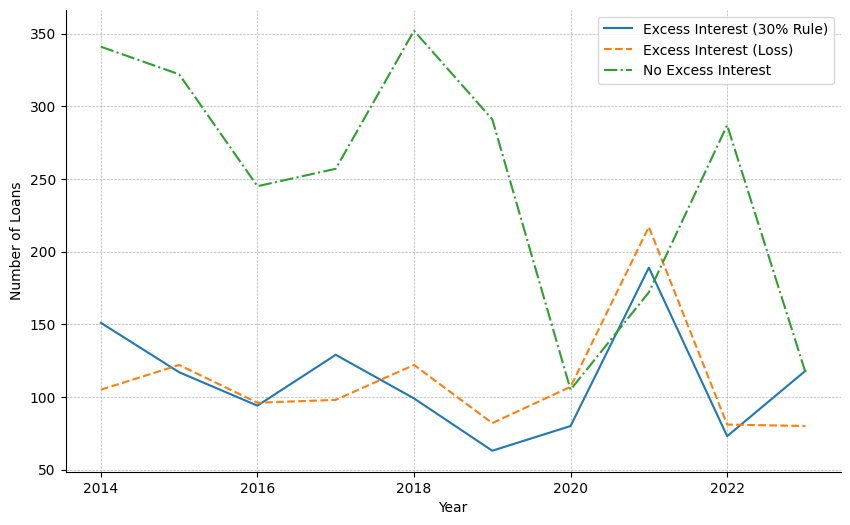

In [370]:
# Create a DataFrame with the number of loans with excess interest and excess loss in each year
excess_interest_30 = tranche_level_ds_compa.groupby('year')['excess_interest_30'].sum()
excess_interest_loss = tranche_level_ds_compa.groupby('year')['excess_interest_loss'].sum()
# Create a DataFrame with the number of loans with No excess interest and No excess loss in each year
no_excess_interest_30_loss = tranche_level_ds_compa.groupby('year')['excess_interest_30'].count() - excess_interest_30 - excess_interest_loss

# plot the number of loans with excess_interest_30 == 1 and excess_loss == 1 and all the rest in each year
plt.figure(figsize=(10, 6))
plt.plot(excess_interest_30, label='Excess Interest (30% Rule)', linestyle='-', marker='')
plt.plot(excess_interest_loss, label='Excess Interest (Loss)', linestyle='--', marker='')
plt.plot(no_excess_interest_30_loss, label='No Excess Interest', linestyle='-.', marker='')
plt.xlabel('Year')
plt.ylabel('Number of Loans')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine(top=True, right=True)
plt.savefig(os.path.join(overleaf_dir, 'Figures/loancounts_by_excess_interest.png'), dpi=300)
plt.show()


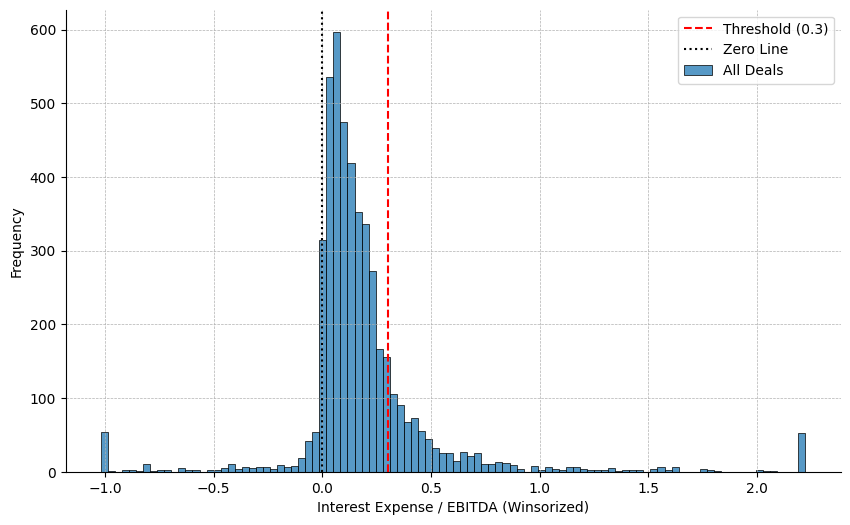

In [371]:
# plot the histogram of winsorized interest_expense_by_ebitda for all deals
interest_expense_winsorized = tranche_level_ds_compa['interest_expense_by_ebitda'].clip(tranche_level_ds_compa['interest_expense_by_ebitda'].quantile(0.01), tranche_level_ds_compa['interest_expense_by_ebitda'].quantile(0.99))
plt.figure(figsize=(10, 6))
sns.histplot(interest_expense_winsorized, bins=100, label='All Deals')
plt.axvline(x=0.3, color='r', linestyle='--', label='Threshold (0.3)')
plt.axvline(x=0, color='k', linestyle=':', label='Zero Line')
plt.xlabel('Interest Expense / EBITDA (Winsorized)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.savefig(os.path.join(overleaf_dir, 'Figures/ie_ebitda_all_deals.png'), dpi=300)
plt.show()

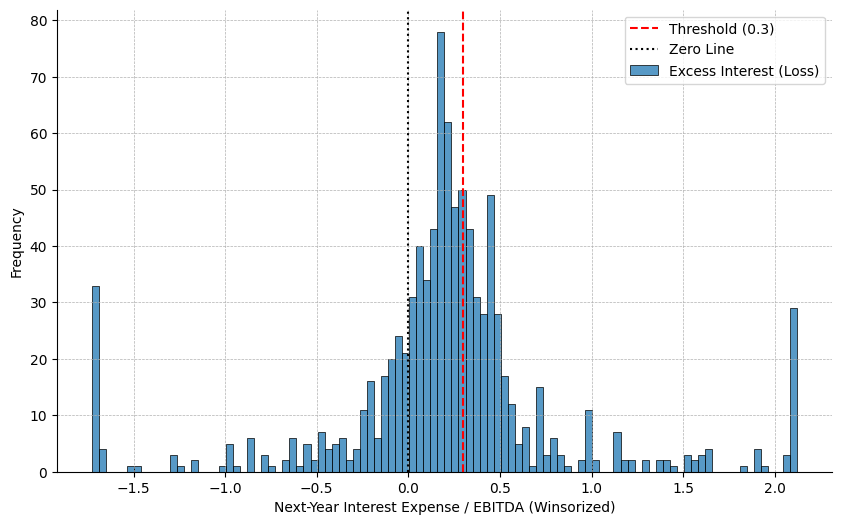

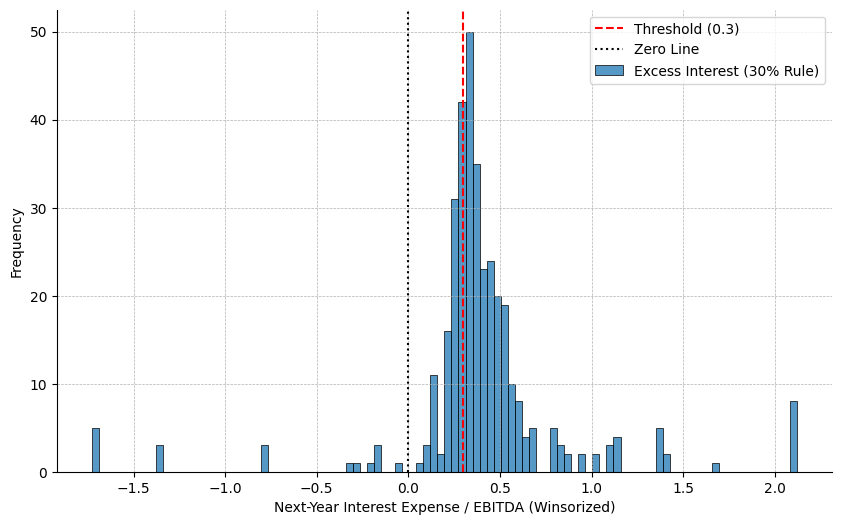

In [372]:
# Plot for excess_interest_loss == 1
interest_expense_winsorized_loss = tranche_level_ds_compa[tranche_level_ds_compa['excess_interest_loss'] == 1]['interest_expense_by_ebitda_next_1yr'].clip(tranche_level_ds_compa['interest_expense_by_ebitda_next_1yr'].quantile(0.01), tranche_level_ds_compa['interest_expense_by_ebitda_next_1yr'].quantile(0.99))
plt.figure(figsize=(10, 6))
sns.histplot(interest_expense_winsorized_loss, bins=100, label='Excess Interest (Loss)')
plt.axvline(x=0.3, color='r', linestyle='--', label='Threshold (0.3)')
plt.axvline(x=0, color='k', linestyle=':', label='Zero Line')
plt.xlabel('Next-Year Interest Expense / EBITDA (Winsorized)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.savefig(os.path.join(overleaf_dir, 'Figures/ie_ebitda_excess_interest_loss_deals.png'), dpi=300)
plt.show()

# Plot for excess_interest_30 == 1
# generate excess_interest_30_only = 1 if excess_interest_30 == 1 and excess_interest_loss == 0
interest_expense_winsorized_30 = tranche_level_ds_compa[(tranche_level_ds_compa['excess_interest_30'] == 1) & (tranche_level_ds_compa['excess_interest_loss'] == 0)]['interest_expense_by_ebitda_next_1yr'].clip(tranche_level_ds_compa['interest_expense_by_ebitda_next_1yr'].quantile(0.01), tranche_level_ds_compa['interest_expense_by_ebitda_next_1yr'].quantile(0.99))
plt.figure(figsize=(10, 6))
sns.histplot(interest_expense_winsorized_30, bins=100, label='Excess Interest (30% Rule)')
plt.axvline(x=0.3, color='r', linestyle='--', label='Threshold (0.3)')
plt.axvline(x=0, color='k', linestyle=':', label='Zero Line')
plt.xlabel('Next-Year Interest Expense / EBITDA (Winsorized)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.savefig(os.path.join(overleaf_dir, 'Figures/ie_ebitda_excess_interest_30_deals.png'), dpi=300)
plt.show()

In [373]:
unique_tranche_types = tranche_level_ds_compa['tranche_type'].unique()
print(unique_tranche_types)

['Delay Draw Term Loan' 'Term Loan B' 'Term Loan A' 'Term Loan D'
 'Term Loan' 'Term Loan E' 'Revolver/Line >= 1 Yr.' 'Term Loan C'
 'Revolver/Line < 1 Yr.' 'Term Loan F' 'Term Loan G' 'Term Loan H'
 'Revolver/Term Loan' 'Term Loan I' 'Term Loan J']


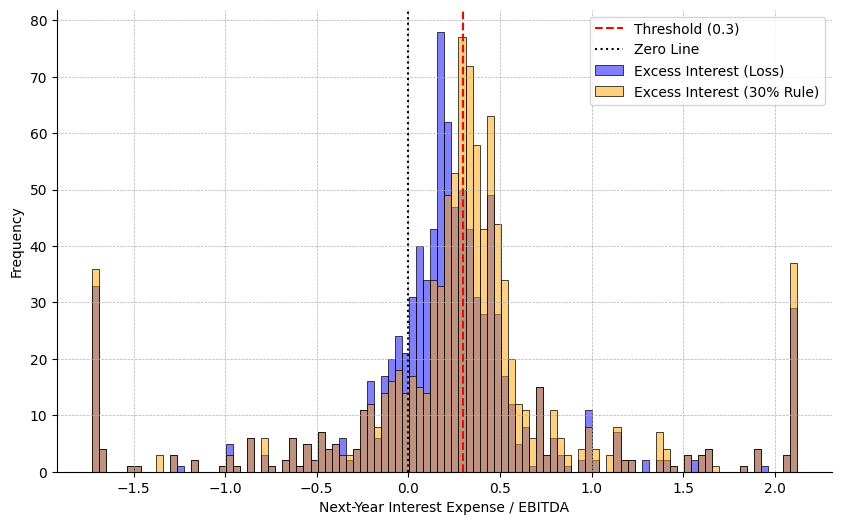

In [374]:
# Plot for excess_interest_loss == 1
interest_expense_winsorized_loss = tranche_level_ds_compa[tranche_level_ds_compa['excess_interest_loss'] == 1]['interest_expense_by_ebitda_next_1yr'].clip(tranche_level_ds_compa['interest_expense_by_ebitda_next_1yr'].quantile(0.01), tranche_level_ds_compa['interest_expense_by_ebitda_next_1yr'].quantile(0.99))

# Plot for excess_interest_30 == 1
interest_expense_winsorized_30 = tranche_level_ds_compa[tranche_level_ds_compa['excess_interest_30'] == 1]['interest_expense_by_ebitda_next_1yr'].clip(tranche_level_ds_compa['interest_expense_by_ebitda_next_1yr'].quantile(0.01), tranche_level_ds_compa['interest_expense_by_ebitda_next_1yr'].quantile(0.99))

plt.figure(figsize=(10, 6))
sns.histplot(interest_expense_winsorized_loss, bins=100, label='Excess Interest (Loss)', color='blue', alpha=0.5)
sns.histplot(interest_expense_winsorized_30, bins=100, label='Excess Interest (30% Rule)', color='orange', alpha=0.5)
plt.axvline(x=0.3, color='r', linestyle='--', label='Threshold (0.3)')
plt.axvline(x=0, color='k', linestyle=':', label='Zero Line')
plt.xlabel('Next-Year Interest Expense / EBITDA')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.savefig(os.path.join(overleaf_dir, 'Figures/ie_ebitda_excess_interest_superimposed.png'), dpi=300)
plt.show()


In [375]:
# summary statistics for the variables in variable_labels for excess_interest_30 == 1 and post == 1
summary_stats_excess_interest_30_post = tranche_level_ds_compa[(tranche_level_ds_compa['excess_interest_30'] == 1) & (tranche_level_ds_compa['post'] == 1)][variable_labels_groups.keys()].describe().transpose()
# summary statistics for the variables in variable_labels for excess_interest_30 == 1 and post == 0
summary_stats_excess_interest_30_pre = tranche_level_ds_compa[(tranche_level_ds_compa['excess_interest_30'] == 1) & (tranche_level_ds_compa['post'] == 0)][variable_labels_groups.keys()].describe().transpose()
# summary statistics for the variables in variable_labels for excess_interest_30 == 0 and post == 1
summary_stats_no_excess_interest_30_post = tranche_level_ds_compa[(tranche_level_ds_compa['excess_interest_30'] == 0) & (tranche_level_ds_compa['post'] == 1)][variable_labels_groups.keys()].describe().transpose()
# summary statistics for the variables in variable_labels for excess_interest_30 == 0 and post == 0
summary_stats_no_excess_interest_30_pre = tranche_level_ds_compa[(tranche_level_ds_compa['excess_interest_30'] == 0) & (tranche_level_ds_compa['post'] == 0)][variable_labels_groups.keys()].describe().transpose()

# do the same for excess_interest_loss and post
summary_stats_excess_interest_loss_post = tranche_level_ds_compa[(tranche_level_ds_compa['excess_interest_loss'] == 1) & (tranche_level_ds_compa['post'] == 1)][variable_labels_groups.keys()].describe().transpose()
summary_stats_excess_interest_loss_pre = tranche_level_ds_compa[(tranche_level_ds_compa['excess_interest_loss'] == 1) & (tranche_level_ds_compa['post'] == 0)][variable_labels_groups.keys()].describe().transpose()
summary_stats_no_excess_interest_loss_post = tranche_level_ds_compa[(tranche_level_ds_compa['excess_interest_loss'] == 0) & (tranche_level_ds_compa['post'] == 1)][variable_labels_groups.keys()].describe().transpose()
summary_stats_no_excess_interest_loss_pre = tranche_level_ds_compa[(tranche_level_ds_compa['excess_interest_loss'] == 0) & (tranche_level_ds_compa['post'] == 0)][variable_labels_groups.keys()].describe().transpose()

# keep only count and mean for each of the eight summary statistics
summary_stats_excess_interest_30_post = summary_stats_excess_interest_30_post[['count', 'mean']]
summary_stats_excess_interest_30_pre = summary_stats_excess_interest_30_pre[['count', 'mean']]
summary_stats_no_excess_interest_30_post = summary_stats_no_excess_interest_30_post[['count', 'mean']]
summary_stats_no_excess_interest_30_pre = summary_stats_no_excess_interest_30_pre[['count', 'mean']]
summary_stats_excess_interest_loss_post = summary_stats_excess_interest_loss_post[['count', 'mean']]
summary_stats_excess_interest_loss_pre = summary_stats_excess_interest_loss_pre[['count', 'mean']]
summary_stats_no_excess_interest_loss_post = summary_stats_no_excess_interest_loss_post[['count', 'mean']]
summary_stats_no_excess_interest_loss_pre = summary_stats_no_excess_interest_loss_pre[['count', 'mean']]

# Bind the summary statistics together for each of the four groups
summary_stats_excess_interest_30 = pd.concat([summary_stats_excess_interest_30_pre, summary_stats_excess_interest_30_post, summary_stats_no_excess_interest_30_pre, summary_stats_no_excess_interest_30_post], axis=1)
# Rename the index using the variable labels
summary_stats_excess_interest_30.rename(index=variable_labels_groups, inplace=True)

# Convert to LaTeX table with specified number format and labels
summary_stats_excess_interest_30.columns = ['Count', 'Mean', 'Count', 'Mean', 'Count', 'Mean', 'Count', 'Mean']
latex_table = tabulate(summary_stats_excess_interest_30, headers="keys", tablefmt="latex", floatfmt=(".2f", ".0f", ".2f", ".0f", ".2f", ".0f", ".2f", ".0f", ".2f"))

# Add another line on top of the table
latex_table = latex_table.replace("\\begin{tabular}{lrrrrrrrr}\n\\hline", 
                                  "\\begin{tabular}{lrrrrrrrr}\n\\hline\\hline\n& \\multicolumn{4}{c}{Treated} & \\multicolumn{4}{c}{Control}\\\\ \cline{2-5} \cline{6-9}\n& \\multicolumn{2}{c}{Pre-TCJA} & \\multicolumn{2}{c}{Post-TCJA} & \\multicolumn{2}{c}{Pre-TCJA} & \\multicolumn{2}{c}{Post-TCJA}\\\\ \cline{2-3} \cline{4-5} \cline{6-7} \cline{8-9}")

# Modify \hline to \hline\hline right before \end{tabular}
latex_table = latex_table.replace("\\hline\n\\end{tabular}", "\\hline\\hline\n\\end{tabular}")

# Print or save the LaTeX table
print(latex_table)
with open(os.path.join(overleaf_dir, 'Tables/summary_stats_excess_interest_30.tex'), 'w') as f:
    f.write(latex_table)

# do the same for excess_interest_loss
summary_stats_excess_interest_loss = pd.concat([summary_stats_excess_interest_loss_pre, summary_stats_excess_interest_loss_post, summary_stats_no_excess_interest_loss_pre, summary_stats_no_excess_interest_loss_post], axis=1)
summary_stats_excess_interest_loss.rename(index=variable_labels_groups, inplace=True)
summary_stats_excess_interest_loss.columns = ['Count', 'Mean', 'Count', 'Mean', 'Count', 'Mean', 'Count', 'Mean']
latex_table = tabulate(summary_stats_excess_interest_loss, headers="keys", tablefmt="latex", floatfmt=(".2f", ".0f", ".2f", ".0f", ".2f", ".0f", ".2f", ".0f", ".2f"))
latex_table = latex_table.replace("\\begin{tabular}{lrrrrrrrr}\n\\hline", 
                                  "\\begin{tabular}{lrrrrrrrr}\n\\hline\\hline\n& \\multicolumn{4}{c}{Treated} & \\multicolumn{4}{c}{Control}\\\\ \cline{2-5} \cline{6-9}\n& \\multicolumn{2}{c}{Pre-TCJA} & \\multicolumn{2}{c}{Post-TCJA} & \\multicolumn{2}{c}{Pre-TCJA} & \\multicolumn{2}{c}{Post-TCJA}\\\\ \cline{2-3} \cline{4-5} \cline{6-7} \cline{8-9}")
latex_table = latex_table.replace("\\hline\n\\end{tabular}", "\\hline\\hline\n\\end{tabular}")
print(latex_table)
with open(os.path.join(overleaf_dir, 'Tables/summary_stats_excess_interest_loss.tex'), 'w') as f:
    f.write(latex_table)

\begin{tabular}{lrrrrrrrr}
\hline\hline
& \multicolumn{4}{c}{Treated} & \multicolumn{4}{c}{Control}\\ \cline{2-5} \cline{6-9}
& \multicolumn{2}{c}{Pre-TCJA} & \multicolumn{2}{c}{Post-TCJA} & \multicolumn{2}{c}{Pre-TCJA} & \multicolumn{2}{c}{Post-TCJA}\\ \cline{2-3} \cline{4-5} \cline{6-7} \cline{8-9}
                                  &   Count &    Mean &   Count &    Mean &   Count &    Mean &   Count &    Mean \\
\hline
 Excess Interest Expense (Scaled) &     491 &    0.60 &     622 &    0.73 &    1586 &    0.07 &    2013 &    0.10 \\
 Net Debt Issues / Assets         &     491 &    0.04 &     622 &    0.01 &    1586 &    0.02 &    2013 &    0.01 \\
 Net Debt Issues / EBITDA         &     491 &    0.22 &     622 &   -0.91 &    1586 &    0.17 &    2013 &    0.07 \\
 Debt / Assets                    &     491 &    0.55 &     622 &    0.51 &    1586 &    0.30 &    2013 &    0.33 \\
 Interest Expense / Debt          &     491 &    0.12 &     622 &    0.09 &    1586 &    0.09 &    2013 & 

<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:53: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:53: SyntaxWarning: invalid escape sequence '\c'
/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_19460/3284375666.py:37: SyntaxWarning: invalid escape sequence '\c'
  "\\begin{tabular}{lrrrrrrrr}\n\\hline\\hline\n& \\multicolumn{4}{c}{Treated} & \\multicolumn{4}{c}{Control}\\\\ \cline{2-5} \cline{6-9}\n& \\multicolumn{2}{c}{Pre-TCJA} & \\multicolumn{2}{c}{Post-TCJA} & \\multicolumn{2}{c}{Pre-TCJA} & \\multicolumn{2}{c}{Post-TCJA}\\\\ \cline{2-3} \cline{4-5} \cline{6-7} \cline{8-9}")
/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_19460/3284375666.py:53: SyntaxWarning: invalid escape sequence '\c'
  "\\begin{tabular}{lrrrrrrrr}\n\\hline\\hline\n& \\multicolumn{4}{c}{Treated} & \\multicolumn{4}{c}{Control}\\\\ \cline{2-5} \cline{6-9}\n& \\multicolumn{2}{c}{Pre-TCJA} & \\multicolumn{2}{c}{Post-TCJA} & \\multicolumn

# Preliminary Analysis

Results on Margin, Number of Financial Covenants, Perf Pricing, and Sweeps

In [376]:
year_dummies = pd.get_dummies(tranche_level_ds_compa['year'], prefix='year', drop_first=False).astype(int)

def output_analysis_dta(definition):
    tranche_level_ds_compa_dta = tranche_level_ds_compa.copy()

    tranche_level_ds_compa_dta['treated'] = (tranche_level_ds_compa_dta[f'excess_interest_30{definition}'] > 0).astype(int)

    # Generated treated_loss = excess_interest_loss = 1
    tranche_level_ds_compa_dta['treated_loss'] = (tranche_level_ds_compa_dta[f'excess_interest_loss{definition}'] > 0).astype(int)

    # post = 1 if year > 2017 (2017 as hold-out period)
    tranche_level_ds_compa_dta['post'] = (tranche_level_ds_compa_dta['year'] > 2017).astype(int)

    # Generate the interaction term
    tranche_level_ds_compa_dta['treated_post'] = tranche_level_ds_compa_dta['treated'] * tranche_level_ds_compa_dta['post']

    # Generate the interaction term for treated loss
    tranche_level_ds_compa_dta['treated_loss_post'] = tranche_level_ds_compa_dta['treated_loss'] * tranche_level_ds_compa_dta['post']

    # Generate interaction terms for each year dummy and the treated_post variable, ensuring integer output
    interactions = year_dummies.apply(lambda x: (x * tranche_level_ds_compa_dta['treated']).astype(int))

    # Generate interaction terms for each year dummy and the treated_loss_post variable, ensuring integer output
    interactions_loss = year_dummies.apply(lambda x: (x * tranche_level_ds_compa_dta['treated_loss']).astype(int))

    # Rename the interaction columns to have 'treated_year' as names
    interactions.columns = [f'treated_{col}' for col in year_dummies.columns]

    # Rename the interaction columns to have 'treated_loss_year' as names
    interactions_loss.columns = [f'treated_loss_{col}' for col in year_dummies.columns]

    # Add the year dummies and interaction terms back to the original data frame
    tranche_level_ds_compa_dta = pd.concat([tranche_level_ds_compa_dta, year_dummies, interactions, interactions_loss], axis=1)

    # drop duplicated columns
    tranche_level_ds_compa_dta = tranche_level_ds_compa_dta.loc[:, ~tranche_level_ds_compa_dta.columns.duplicated()]

    # Convert ipodate to string to avoid ValueError
    tranche_level_ds_compa_dta['ipodate'] = tranche_level_ds_compa_dta['ipodate'].astype(str)
    
    # save as .dta with version=117
    tranche_level_ds_compa_dta.to_stata(f'../3. Data/Processed/tranche_level_ds_compa{definition}.dta', version=117)

output_analysis_dta('')
output_analysis_dta('_prev_3yr')
output_analysis_dta('_prev_5yr')

/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_19460/327087554.py:42: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    interest_expense_by_ebitda_next_1yr   ->   interest_expense_by_ebitda_next_

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  tranche_level_ds_compa_dta.to_stata(f'../3. Data/Processed/tranche_level_ds_compa{definition}.dta', version=117)
/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_19460/327087554.py:42: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    interest_expense_by_ebitda_next_1yr   ->   interest_expense_by_ebitda_next_

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (st

In [377]:
tranche_level_ds_compa_dta = tranche_level_ds_compa.copy()

tranche_level_ds_compa_dta['treated'] = (tranche_level_ds_compa_dta[f'excess_interest_30'] > 0).astype(int)
tranche_level_ds_compa_dta['treated_prev_3yr'] = (tranche_level_ds_compa_dta[f'excess_interest_30_prev_3yr'] > 0).astype(int)
tranche_level_ds_compa_dta['treated_prev_5yr'] = (tranche_level_ds_compa_dta[f'excess_interest_30_prev_5yr'] > 0).astype(int)
tranche_level_ds_compa_dta['treated_next_1yr'] = (tranche_level_ds_compa_dta[f'excess_interest_30_next_1yr'] > 0).astype(int)
tranche_level_ds_compa_dta['treated_next_3yr'] = (tranche_level_ds_compa_dta[f'excess_interest_30_next_3yr'] > 0).astype(int)
tranche_level_ds_compa_dta['treated_next_5yr'] = (tranche_level_ds_compa_dta[f'excess_interest_30_next_5yr'] > 0).astype(int)

# Generated treated_loss = excess_interest_loss = 1
tranche_level_ds_compa_dta['treated_loss'] = (tranche_level_ds_compa_dta[f'excess_interest_loss'] > 0).astype(int)
tranche_level_ds_compa_dta['treated_loss_prev_3yr'] = (tranche_level_ds_compa_dta[f'excess_interest_loss_prev_3yr'] > 0).astype(int)
tranche_level_ds_compa_dta['treated_loss_prev_5yr'] = (tranche_level_ds_compa_dta[f'excess_interest_loss_prev_5yr'] > 0).astype(int)
tranche_level_ds_compa_dta['treated_loss_next_1yr'] = (tranche_level_ds_compa_dta[f'excess_interest_loss_next_1yr'] > 0).astype(int)
tranche_level_ds_compa_dta['treated_loss_next_3yr'] = (tranche_level_ds_compa_dta[f'excess_interest_loss_next_3yr'] > 0).astype(int)
tranche_level_ds_compa_dta['treated_loss_next_5yr'] = (tranche_level_ds_compa_dta[f'excess_interest_loss_next_5yr'] > 0).astype(int)

# Generate the interaction term
tranche_level_ds_compa_dta['treated_post'] = tranche_level_ds_compa_dta['treated'] * tranche_level_ds_compa_dta['post']
tranche_level_ds_compa_dta['treated_prev_3yr_post'] = tranche_level_ds_compa_dta['treated_prev_3yr'] * tranche_level_ds_compa_dta['post']
tranche_level_ds_compa_dta['treated_prev_5yr_post'] = tranche_level_ds_compa_dta['treated_prev_5yr'] * tranche_level_ds_compa_dta['post']
tranche_level_ds_compa_dta['treated_next_1yr_post'] = tranche_level_ds_compa_dta['treated_next_1yr'] * tranche_level_ds_compa_dta['post']
tranche_level_ds_compa_dta['treated_next_3yr_post'] = tranche_level_ds_compa_dta['treated_next_3yr'] * tranche_level_ds_compa_dta['post']
tranche_level_ds_compa_dta['treated_next_5yr_post'] = tranche_level_ds_compa_dta['treated_next_5yr'] * tranche_level_ds_compa_dta['post']

# Generate the interaction term for treated loss
tranche_level_ds_compa_dta['treated_loss_post'] = tranche_level_ds_compa_dta['treated_loss'] * tranche_level_ds_compa_dta['post']
tranche_level_ds_compa_dta['treated_loss_prev_3yr_post'] = tranche_level_ds_compa_dta['treated_loss_prev_3yr'] * tranche_level_ds_compa_dta['post']
tranche_level_ds_compa_dta['treated_loss_prev_5yr_post'] = tranche_level_ds_compa_dta['treated_loss_prev_5yr'] * tranche_level_ds_compa_dta['post']
tranche_level_ds_compa_dta['treated_loss_next_1yr_post'] = tranche_level_ds_compa_dta['treated_loss_next_1yr'] * tranche_level_ds_compa_dta['post']
tranche_level_ds_compa_dta['treated_loss_next_3yr_post'] = tranche_level_ds_compa_dta['treated_loss_next_3yr'] * tranche_level_ds_compa_dta['post']
tranche_level_ds_compa_dta['treated_loss_next_5yr_post'] = tranche_level_ds_compa_dta['treated_loss_next_5yr'] * tranche_level_ds_compa_dta['post']

# Generate interaction terms for each year dummy and the treated_post variable, ensuring integer output
interactions = year_dummies.apply(lambda x: (x * tranche_level_ds_compa_dta['treated']).astype(int))
interactions_prev_3yr = year_dummies.apply(lambda x: (x * tranche_level_ds_compa_dta['treated_prev_3yr']).astype(int))
interactions_prev_5yr = year_dummies.apply(lambda x: (x * tranche_level_ds_compa_dta['treated_prev_5yr']).astype(int))
interactions_next_1yr = year_dummies.apply(lambda x: (x * tranche_level_ds_compa_dta['treated_next_1yr']).astype(int))
interactions_next_3yr = year_dummies.apply(lambda x: (x * tranche_level_ds_compa_dta['treated_next_3yr']).astype(int))
interactions_next_5yr = year_dummies.apply(lambda x: (x * tranche_level_ds_compa_dta['treated_next_5yr']).astype(int))

# Generate interaction terms for each year dummy and the treated_loss_post variable, ensuring integer output
interactions_loss = year_dummies.apply(lambda x: (x * tranche_level_ds_compa_dta['treated_loss']).astype(int))
interactions_loss_prev_3yr = year_dummies.apply(lambda x: (x * tranche_level_ds_compa_dta['treated_loss_prev_3yr']).astype(int))
interactions_loss_prev_5yr = year_dummies.apply(lambda x: (x * tranche_level_ds_compa_dta['treated_loss_prev_5yr']).astype(int))
interactions_loss_next_1yr = year_dummies.apply(lambda x: (x * tranche_level_ds_compa_dta['treated_loss_next_1yr']).astype(int))
interactions_loss_next_3yr = year_dummies.apply(lambda x: (x * tranche_level_ds_compa_dta['treated_loss_next_3yr']).astype(int))
interactions_loss_next_5yr = year_dummies.apply(lambda x: (x * tranche_level_ds_compa_dta['treated_loss_next_5yr']).astype(int))

# Rename the interaction columns to have 'treated_year' as names 
interactions.columns = [f'treated_{col}' for col in year_dummies.columns]
interactions_prev_3yr.columns = [f'treated_prev_3yr_{col}' for col in year_dummies.columns]
interactions_prev_5yr.columns = [f'treated_prev_5yr_{col}' for col in year_dummies.columns]
interactions_next_1yr.columns = [f'treated_next_1yr_{col}' for col in year_dummies.columns]
interactions_next_3yr.columns = [f'treated_next_3yr_{col}' for col in year_dummies.columns]
interactions_next_5yr.columns = [f'treated_next_5yr_{col}' for col in year_dummies.columns]

# Rename the interaction columns to have 'treated_loss_year' as names
interactions_loss.columns = [f'treated_loss_{col}' for col in year_dummies.columns]
interactions_loss_prev_3yr.columns = [f'treated_loss_prev_3yr_{col}' for col in year_dummies.columns]
interactions_loss_prev_5yr.columns = [f'treated_loss_prev_5yr_{col}' for col in year_dummies.columns]
interactions_loss_next_1yr.columns = [f'treated_loss_next_1yr_{col}' for col in year_dummies.columns]
interactions_loss_next_3yr.columns = [f'treated_loss_next_3yr_{col}' for col in year_dummies.columns]
interactions_loss_next_5yr.columns = [f'treated_loss_next_5yr_{col}' for col in year_dummies.columns]

# Add the year dummies and interaction terms back to the original data frame
tranche_level_ds_compa_dta = pd.concat([tranche_level_ds_compa_dta, year_dummies, interactions, interactions_prev_3yr, interactions_prev_5yr, interactions_next_1yr, interactions_next_3yr, interactions_next_5yr, 
                                        interactions_loss, interactions_loss_prev_3yr, interactions_loss_prev_5yr, interactions_loss_next_1yr, interactions_loss_next_3yr, interactions_loss_next_5yr], axis=1)

# drop duplicated columns
tranche_level_ds_compa_dta = tranche_level_ds_compa_dta.loc[:, ~tranche_level_ds_compa_dta.columns.duplicated()]

# Convert ipodate to string to avoid ValueError
tranche_level_ds_compa_dta['ipodate'] = tranche_level_ds_compa_dta['ipodate'].astype(str)
    
# save as .dta with version=117
tranche_level_ds_compa_dta.to_stata(f'../3. Data/Processed/tranche_level_ds_compa.dta', version=117)

/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_19460/2738183050.py:77: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    interest_expense_by_ebitda_next_1yr   ->   interest_expense_by_ebitda_next_

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  tranche_level_ds_compa_dta.to_stata(f'../3. Data/Processed/tranche_level_ds_compa.dta', version=117)


In [378]:
def plot_dynamic_did(filename, definition, title):    
    # Remove unwanted characters from the column names and values
        result = pd.read_csv(f'{overleaf_dir}/Tables/{definition}/{filename}.csv')
        result.columns = result.columns.str.replace('="', '').str.replace('"', '')
        result = result.apply(lambda x: x.str.replace('="', '').replace('"', '') if x.dtype == "object" else x)

        # Rename columns as Year, Coefficient, and Standard Error
        result.columns = ['Year', 'Coefficient', 'Standard Error']

        # keep only the rows with treated_year
        result = result[result['Year'].str.startswith('treated_')]

        # destring the Year column
        #result['Year'] = result['Year'].str.replace('treated_year_', '').str.replace('"', '').astype(int)
        result['Year'] = result['Year'].str.replace(r'^.*year_', '', regex=True).str.replace('"', '').astype(int)

        # Clean and convert coefficient and standard error columns
        result['Coefficient'] = result['Coefficient'].str.replace('"', '').astype(float)
        result['Standard Error'] = result['Standard Error'].str.replace('"', '').astype(float)

        # Plot the dynamic treatment effect (Coefficient across years with 1.96 standard error bands)
        plt.figure(figsize=(12, 6))
        plt.errorbar(result['Year'], result['Coefficient'], yerr=1.96*result['Standard Error'], fmt='o', color='blue')
        plt.axhline(y=0, color='red', linestyle='--')
        plt.scatter(2017, 0, color='blue', zorder=5)  # Add a dot in year 2017 at 0
        plt.title(title)
        plt.xlabel('Year')
        plt.ylabel('Coefficient')
        plt.grid(True, linestyle='--', linewidth=0.5)
        sns.despine()
        plt.savefig(f'{overleaf_dir}/Figures/{definition}/{filename}.png')
    # close the plot to save memory
    # plt.close()

def plot_all_dynamic_did(definition):
    plot_dynamic_did('margin_did_dynamic_gvkey', definition, 'Dynamic DID: Firm FE')
    plot_dynamic_did('margin_did_dynamic_ff48', definition, 'Dynamic DID: FF48 FE')
    plot_dynamic_did('num_fin_cov_did_dynamic_gvkey', definition, 'Dynamic DID: Num of Financial Covenants (Firm FE)')
    plot_dynamic_did('num_fin_cov_did_dynamic_ff48', definition, 'Dynamic DID: Num of Financial Covenants (FF48 FE)')
    plot_dynamic_did('perf_pricing_dummy_did_dynamic_gvkey', definition, 'Dynamic DID: Performance Pricing (Firm FE)')
    plot_dynamic_did('perf_pricing_dummy_did_dynamic_ff48', definition, 'Dynamic DID: Performance Pricing (FF48 FE)')
    plot_dynamic_did('sweep_dummy_did_dynamic_gvkey', definition, 'Dynamic DID: Sweep (Firm FE)')
    plot_dynamic_did('sweep_dummy_did_dynamic_ff48', definition, 'Dynamic DID: Sweep (FF48 FE)')

#plot_all_dynamic_did('')
#plot_all_dynamic_did('Prev_3yr_definition')
#plot_all_dynamic_did('Prev_5yr_definition')
#plot_dynamic_did('margin_did_dynamic_loss_ff48', 'Current_yr_definition', 'Dynamic DID: Loss Rule (FF48 FE)')

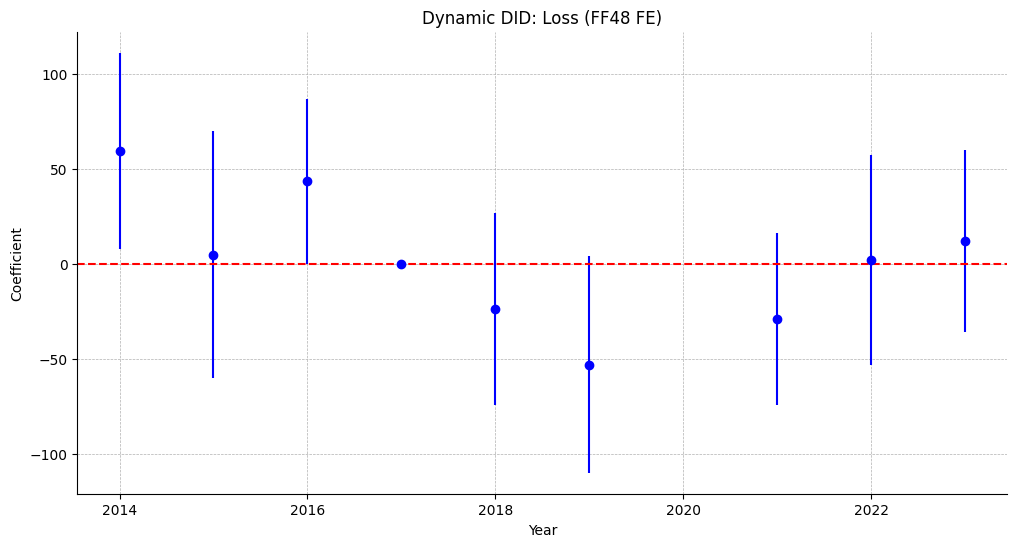

In [379]:
result = pd.read_csv(f'{overleaf_dir}/Tables/margin_did_dynamic_loss_ff48.csv')
result.columns = result.columns.str.replace('="', '').str.replace('"', '')
result = result.apply(lambda x: x.str.replace('="', '').replace('"', '') if x.dtype == "object" else x)

# Rename columns as Year, Coefficient, and Standard Error
result.columns = ['Year', 'Coefficient', 'Standard Error']

# keep only the rows with treated_year
result = result[result['Year'].str.startswith('treated_loss_year')]

# destring the Year column
#result['Year'] = result['Year'].str.replace('treated_year_', '').str.replace('"', '').astype(int)
result['Year'] = result['Year'].str.replace(r'^.*year_', '', regex=True).str.replace('"', '').astype(int)

# Clean and convert coefficient and standard error columns
result['Coefficient'] = result['Coefficient'].str.replace('"', '').astype(float)
result['Standard Error'] = result['Standard Error'].str.replace('"', '').astype(float)

# Plot the dynamic treatment effect (Coefficient across years with 1.96 standard error bands)
plt.figure(figsize=(12, 6))
plt.errorbar(result['Year'], result['Coefficient'], yerr=1.645*result['Standard Error'], fmt='o', color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.scatter(2017, 0, color='blue', zorder=5)  # Add a dot in year 2017 at 0
plt.title('Dynamic DID: Loss (FF48 FE)')
plt.xlabel('Year')
plt.ylabel('Coefficient')
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.savefig(f'{overleaf_dir}/Figures/margin_did_dynamic_loss_ff48.png')

# DTA Analysis 

In [380]:
# generate list of gvkey from tranche_level_ds_compa
gvkey_list = tranche_level_ds_compa['gvkey'].unique()

# rename txdba, txdbca, txndb to DTA, DTA_current, NDTA
comp_crspa_merged = comp_crspa_merged.rename(columns={'txdba': 'DTA', 'txdbca': 'DTA_current', 'txndb': 'NDTA'})

# inner merge with gvkey_list
dta_analysis = comp_crspa_merged[comp_crspa_merged['gvkey'].isin(gvkey_list)]

# keep year >= 2014 and <= 2023
dta_analysis = dta_analysis[dta_analysis['fyear'] <= 2023]
dta_analysis = dta_analysis[dta_analysis['fyear'] >= 2014]

# check if there are duplicated gvkey and fyear
dta_analysis[dta_analysis.duplicated(subset=['gvkey', 'fyear'], keep=False)]

,gvkey,datadate,conm,tic,cusip,fyear,fyr,at,capx,ceq,...,interest_expense_by_ebitda_next_1yr,permno,ret_buy_and_hold,ret_vol,dlstcd,lpermno,linktype,linkprim,linkdt,linkenddt
371,1380,2014-12-31,HESS CORP,HES,42809H107,2014,12,38578.000,5274.000,22205.000,...,0.201988,28484,-0.100258,0.074595,100,28484.0,LC,P,1964-03-31,2024-12-31
372,1380,2014-12-31,HESS CORP,HES,42809H107,2014,12,38578.000,5274.000,22205.000,...,0.201988,28484,-0.100258,0.074595,100,28484.0,LX,N,1998-05-29,2016-11-30
373,1380,2015-12-31,HESS CORP,HES,42809H107,2015,12,34195.000,4321.000,19386.000,...,0.360108,28484,-0.331652,0.111898,100,28484.0,LC,P,1964-03-31,2024-12-31
374,1380,2015-12-31,HESS CORP,HES,42809H107,2015,12,34195.000,4321.000,19386.000,...,0.360108,28484,-0.331652,0.111898,100,28484.0,LX,N,1998-05-29,2016-11-30
375,1380,2016-12-31,HESS CORP,HES,42809H107,2016,12,28621.000,2251.000,14533.000,...,-0.188101,28484,0.307603,0.110360,100,28484.0,LC,P,1964-03-31,2024-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57929,271357,2020-12-31,SUMMIT THERAPEUTICS INC,SMMT,86627T108,2020,12,102.498,0.421,79.453,...,-0.003312,15274,1.156251,0.343996,331,15274.0,LC,N,2020-09-21,2020-09-30
57930,271357,2020-12-31,SUMMIT THERAPEUTICS INC,SMMT,86627T108,2020,12,102.498,0.421,79.453,...,-0.003312,19849,0.366278,0.223586,100,19849.0,LC,P,2020-09-21,2024-12-31
57972,272838,2019-12-31,SUNDANCE ENERGY AUSTRALIA,SNDEQ,86725N102,2019,12,813.914,167.372,353.397,...,-0.125808,16306,0.781535,NaN,574,16306.0,LC,P,2019-11-26,2021-04-30
57973,272838,2019-12-31,SUNDANCE ENERGY AUSTRALIA,SNDEQ,86725N102,2019,12,813.914,167.372,353.397,...,-0.125808,19667,-0.613999,0.228573,331,19667.0,LC,P,2016-09-02,2019-10-31


In [381]:
# sort by gvkey and fyear
dta_analysis = dta_analysis.sort_values(by=['gvkey', 'fyear'])
# scale by total assets
dta_analysis['DTA_byat'] = dta_analysis['DTA'] / dta_analysis['at']
# generate delta_DTA
dta_analysis['delta_DTA'] = dta_analysis.groupby('gvkey')['DTA'].diff()
# scale by total assets
dta_analysis['delta_DTA_byat'] = dta_analysis['delta_DTA'] / dta_analysis['at']
# check for correlation between DTA and excess_interest_30 and excess_interest_loss
dta_analysis[['DTA', 'delta_DTA', 'DTA_byat', 'delta_DTA_byat', 'excess_interest_30', 'excess_interest_loss']].corr()
# save to dta
dta_analysis.to_stata('../3. Data/Processed/dta_analysis.dta', version=117)

/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_19460/1944571832.py:12: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    excess_interest_loss_prev_3yr_sum   ->   excess_interest_loss_prev_3yr_su
    excess_interest_loss_prev_5yr_sum   ->   excess_interest_loss_prev_5yr_su
    excess_interest_loss_next_1yr_sum   ->   excess_interest_loss_next_1yr_su
    excess_interest_loss_next_3yr_sum   ->   excess_interest_loss_next_3yr_su
    excess_interest_loss_next_5yr_sum   ->   excess_interest_loss_next_5yr_su
    interest_expense_by_ebitda_next_1yr   ->   interest_expense_by_ebitda_next_

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  dta_analysis.to_stata('../3. Data/Processed/dta_analysis.dta', version=117)


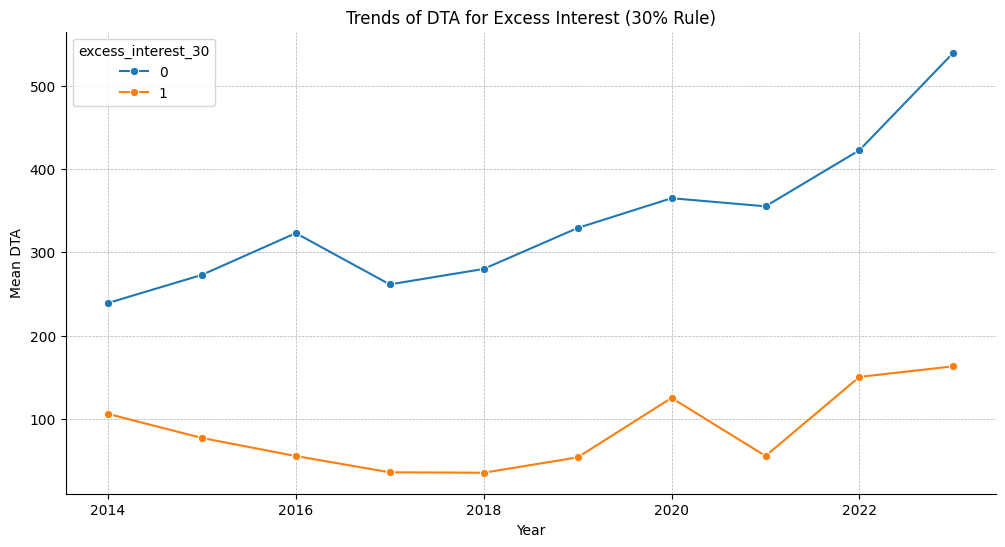

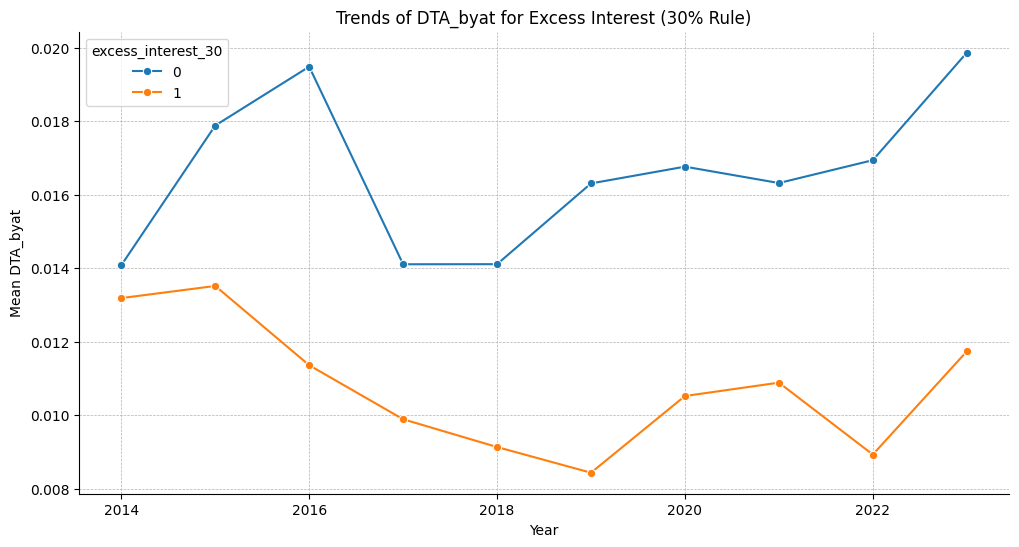

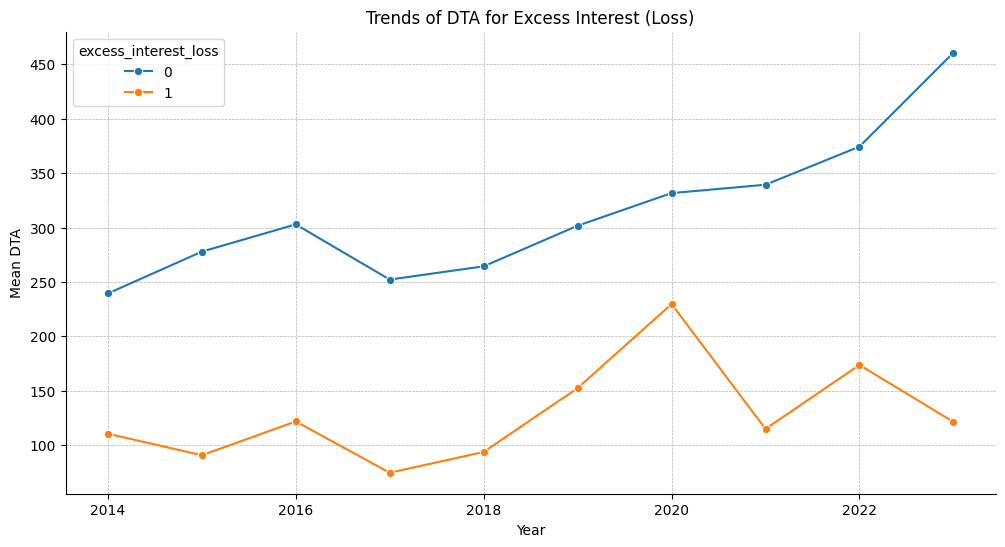

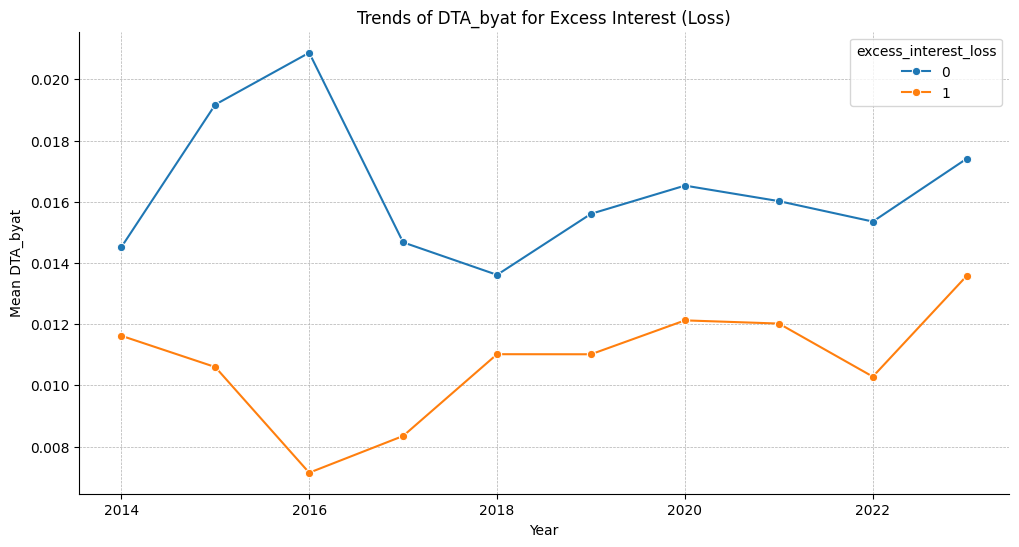

In [382]:
# collapse the data to excess_interest_30 and year, calculate the mean of DTA, DTA_byat
DTA_trends_30 = dta_analysis.groupby(['excess_interest_30', 'fyear']).agg({
    'DTA': 'mean',
    'DTA_byat': 'mean',
}).reset_index()

# Do the same for excess_interest_loss
DTA_trends_loss = dta_analysis.groupby(['excess_interest_loss', 'fyear']).agg({
    'DTA': 'mean',
    'DTA_byat': 'mean',
}).reset_index()

# plot the trends of DTA and DTA_byat for excess_interest_30
plt.figure(figsize=(12, 6))
sns.lineplot(data=DTA_trends_30, x='fyear', y='DTA', hue='excess_interest_30', marker='o')
plt.title('Trends of DTA for Excess Interest (30% Rule)')
plt.xlabel('Year')
plt.ylabel('Mean DTA')
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.savefig(f'{overleaf_dir}/Figures/DTA_trends_30.png')

plt.figure(figsize=(12, 6))
sns.lineplot(data=DTA_trends_30, x='fyear', y='DTA_byat', hue='excess_interest_30', marker='o')
plt.title('Trends of DTA_byat for Excess Interest (30% Rule)')
plt.xlabel('Year')
plt.ylabel('Mean DTA_byat')
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.savefig(f'{overleaf_dir}/Figures/DTA_byat_trends_30.png')

# plot the trends of DTA and DTA_byat for excess_interest_loss
plt.figure(figsize=(12, 6))
sns.lineplot(data=DTA_trends_loss, x='fyear', y='DTA', hue='excess_interest_loss', marker='o')
plt.title('Trends of DTA for Excess Interest (Loss)')
plt.xlabel('Year')
plt.ylabel('Mean DTA')
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.savefig(f'{overleaf_dir}/Figures/DTA_trends_loss.png')

plt.figure(figsize=(12, 6))
sns.lineplot(data=DTA_trends_loss, x='fyear', y='DTA_byat', hue='excess_interest_loss', marker='o')
plt.title('Trends of DTA_byat for Excess Interest (Loss)')
plt.xlabel('Year')
plt.ylabel('Mean DTA_byat')
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.savefig(f'{overleaf_dir}/Figures/DTA_byat_trends_loss.png')

# MTR Analysis

In [383]:
# import the data
mtr8022 = np.genfromtxt('../3. Data/Raw/mtr8022.dat', delimiter=' ', missing_values='.', filling_values=np.nan)
# rename columns to cnum, fyear, mtr_before_ie, mtr_after_ie, permno, gvkey
mtr8022 = pd.DataFrame(mtr8022, columns=['cnum', 'fyear', 'mtr_before_ie', 'mtr_after_ie', 'permno', 'gvkey'])
# generate list of gvkey from tranche_level_ds_compa
gvkey_list_2 = tranche_level_ds_compa[['gvkey', 'excess_interest_30', 'excess_interest_loss']].drop_duplicates()
# for each gvkey, only keep the one with the maximum excess_interest_30 and excess_interest_loss
gvkey_list_2 = gvkey_list_2.groupby('gvkey').agg({
    'excess_interest_30': 'max',
    'excess_interest_loss': 'max'
}).reset_index()

# inner merge with gvkey_list_2
mtr8022 = mtr8022.merge(gvkey_list_2, on='gvkey')

# save to dta
mtr8022.to_stata('../3. Data/Processed/mtr8022.dta', version=117)

In [384]:
# Generate treated_one if only excess_interest_30 == 1
mtr8022['treated_one'] = ((mtr8022['excess_interest_30'] == 1) & (mtr8022['excess_interest_loss'] == 0)).astype(int)

# Generate treated_two if only excess_interest_loss == 1
mtr8022['treated_two'] = ((mtr8022['excess_interest_loss'] == 1) & (mtr8022['excess_interest_30'] == 0)).astype(int)

# Generate treated_three if both excess_interest_30 == 1 and excess_interest_loss == 1
mtr8022['treated_three'] = ((mtr8022['excess_interest_30'] == 1) & (mtr8022['excess_interest_loss'] == 1)).astype(int)

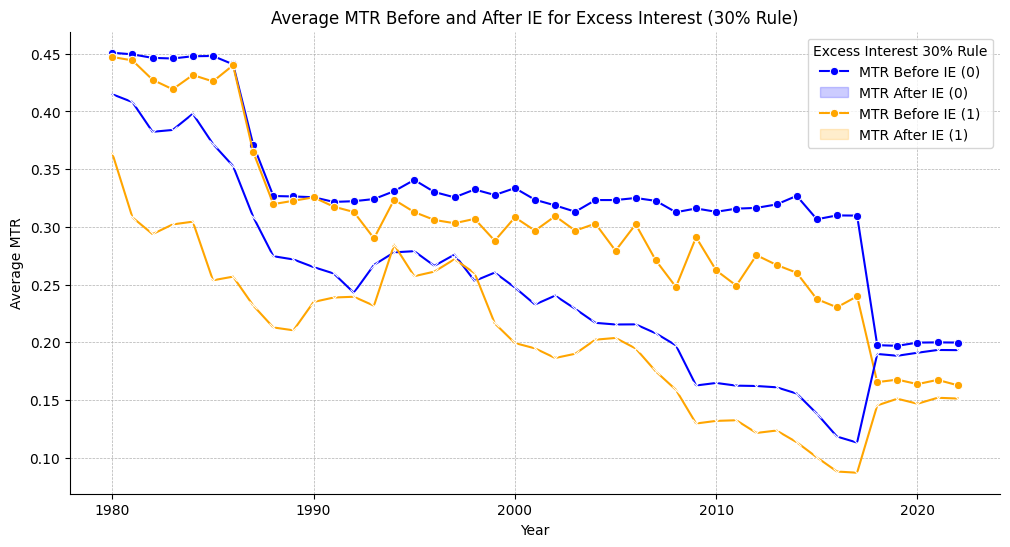

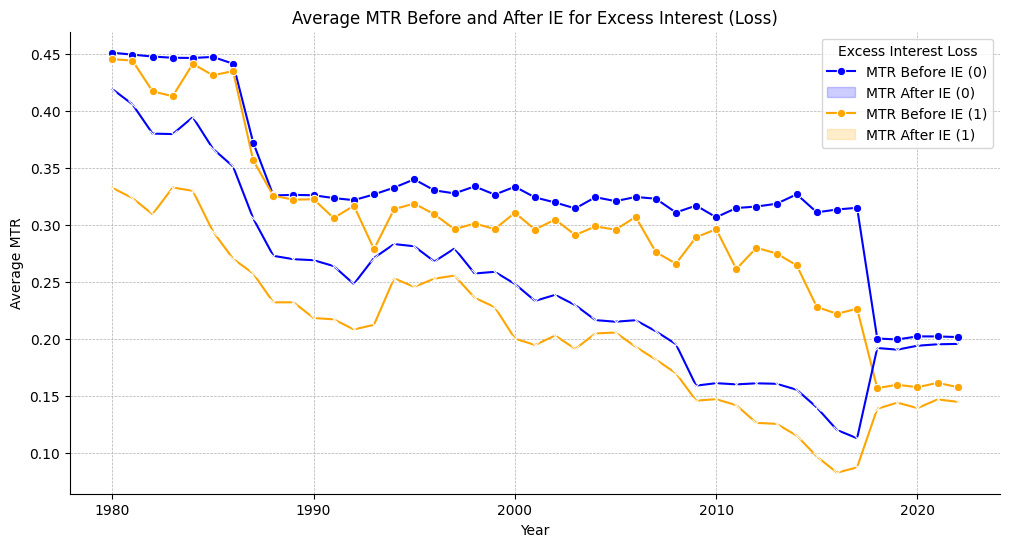

In [385]:
# Calculate the average mtr_before_ie and mtr_after_ie for excess_interest_30 == 1 and 0
mtr_avg_30 = mtr8022.groupby(['excess_interest_30', 'fyear']).agg({
    'mtr_before_ie': 'mean',
    'mtr_after_ie': 'mean'
}).reset_index()

# Calculate the average mtr_before_ie and mtr_after_ie for excess_interest_loss == 1 and 0
mtr_avg_loss = mtr8022.groupby(['excess_interest_loss', 'fyear']).agg({
    'mtr_before_ie': 'mean',
    'mtr_after_ie': 'mean'
}).reset_index()

# Plot the average mtr_before_ie and mtr_after_ie for excess_interest_30
plt.figure(figsize=(12, 6))
sns.lineplot(data=mtr_avg_30, x='fyear', y='mtr_before_ie', hue='excess_interest_30', marker='o', palette={0: 'blue', 1: 'orange'})
sns.lineplot(data=mtr_avg_30, x='fyear', y='mtr_after_ie', hue='excess_interest_30', marker='x', palette={0: 'blue', 1: 'orange'})
plt.title('Average MTR Before and After IE for Excess Interest (30% Rule)')
plt.xlabel('Year')
plt.ylabel('Average MTR')
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.legend(title='Excess Interest 30% Rule', labels=['MTR Before IE (0)', 'MTR After IE (0)', 'MTR Before IE (1)', 'MTR After IE (1)'])
plt.savefig(f'{overleaf_dir}/Figures/mtr_avg_30.png')

# Plot the average mtr_before_ie and mtr_after_ie for excess_interest_loss
plt.figure(figsize=(12, 6))
sns.lineplot(data=mtr_avg_loss, x='fyear', y='mtr_before_ie', hue='excess_interest_loss', marker='o', palette={0: 'blue', 1: 'orange'})
sns.lineplot(data=mtr_avg_loss, x='fyear', y='mtr_after_ie', hue='excess_interest_loss', marker='x', palette={0: 'blue', 1: 'orange'})
plt.title('Average MTR Before and After IE for Excess Interest (Loss)')
plt.xlabel('Year')
plt.ylabel('Average MTR')
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.legend(title='Excess Interest Loss', labels=['MTR Before IE (0)', 'MTR After IE (0)', 'MTR Before IE (1)', 'MTR After IE (1)'])
plt.savefig(f'{overleaf_dir}/Figures/mtr_avg_loss.png')

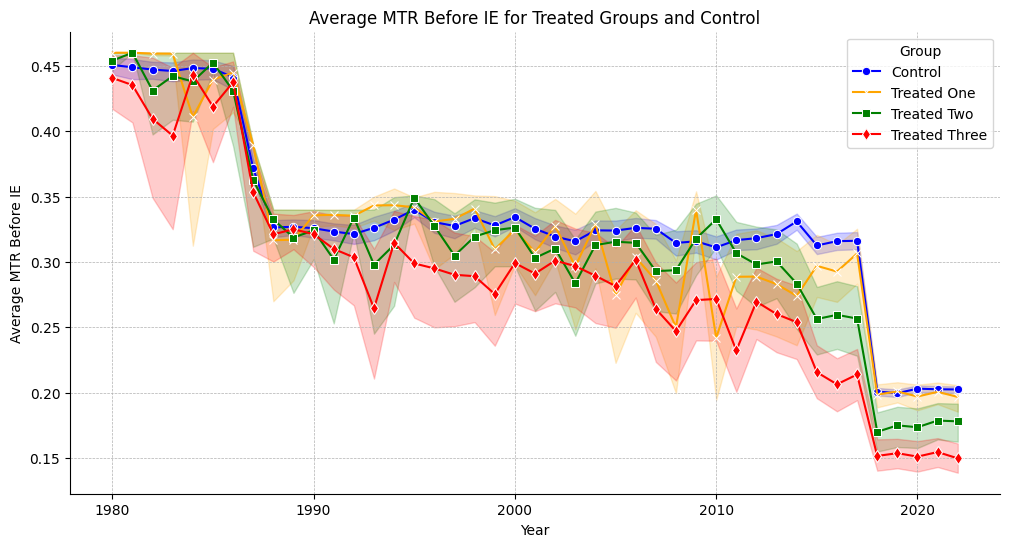

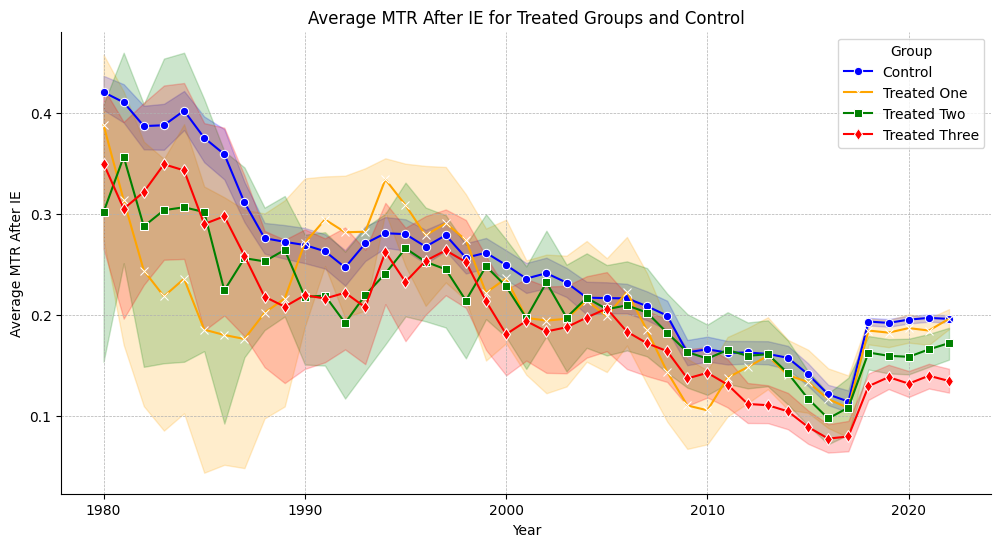

In [386]:
# Create a control group where none of the treated_one, treated_two, or treated_three is equal to 1
mtr8022['control'] = ((mtr8022['treated_one'] == 0) & (mtr8022['treated_two'] == 0) & (mtr8022['treated_three'] == 0)).astype(int)

# Plot the average mtr_before_ie for treated_one, treated_two, treated_three, and control
plt.figure(figsize=(12, 6))
sns.lineplot(data=mtr8022[mtr8022['control'] == 1], x='fyear', y='mtr_before_ie', label='Control', marker='o', color='blue')
sns.lineplot(data=mtr8022[mtr8022['treated_one'] == 1], x='fyear', y='mtr_before_ie', label='Treated One', marker='x', color='orange')
sns.lineplot(data=mtr8022[mtr8022['treated_two'] == 1], x='fyear', y='mtr_before_ie', label='Treated Two', marker='s', color='green')
sns.lineplot(data=mtr8022[mtr8022['treated_three'] == 1], x='fyear', y='mtr_before_ie', label='Treated Three', marker='d', color='red')
plt.title('Average MTR Before IE for Treated Groups and Control')
plt.xlabel('Year')
plt.ylabel('Average MTR Before IE')
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.legend(title='Group')
plt.savefig(f'{overleaf_dir}/Figures/mtr_avg_treated_control.png')
plt.show()

# Plot the average mtr_after_ie for treated_one, treated_two, treated_three, and control
plt.figure(figsize=(12, 6))
sns.lineplot(data=mtr8022[mtr8022['control'] == 1], x='fyear', y='mtr_after_ie', label='Control', marker='o', color='blue')
sns.lineplot(data=mtr8022[mtr8022['treated_one'] == 1], x='fyear', y='mtr_after_ie', label='Treated One', marker='x', color='orange')
sns.lineplot(data=mtr8022[mtr8022['treated_two'] == 1], x='fyear', y='mtr_after_ie', label='Treated Two', marker='s', color='green')
sns.lineplot(data=mtr8022[mtr8022['treated_three'] == 1], x='fyear', y='mtr_after_ie', label='Treated Three', marker='d', color='red')
plt.title('Average MTR After IE for Treated Groups and Control')
plt.xlabel('Year')
plt.ylabel('Average MTR After IE')
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.legend(title='Group')
plt.savefig(f'{overleaf_dir}/Figures/mtr_avg_treated_control_after_ie.png')
plt.show()


In [387]:
# Filter the data for control == 0 firms after 2018
filtered_data = mtr8022[(mtr8022['excess_interest_loss'] == 1) & (mtr8022['fyear'] >= 2018)]

# Calculate the average mtr_before_ie
average_mtr_before_ie = filtered_data['mtr_before_ie'].mean()

print("Average mtr_before_ie for control == 0 firms after 2018:", average_mtr_before_ie)

Average mtr_before_ie for control == 0 firms after 2018: 0.15901395467032967


# Analysis on Persistence of Treatment Groups
Understand if our treatment group definition correctly predicts the probability of future possibility of crossing the threshold

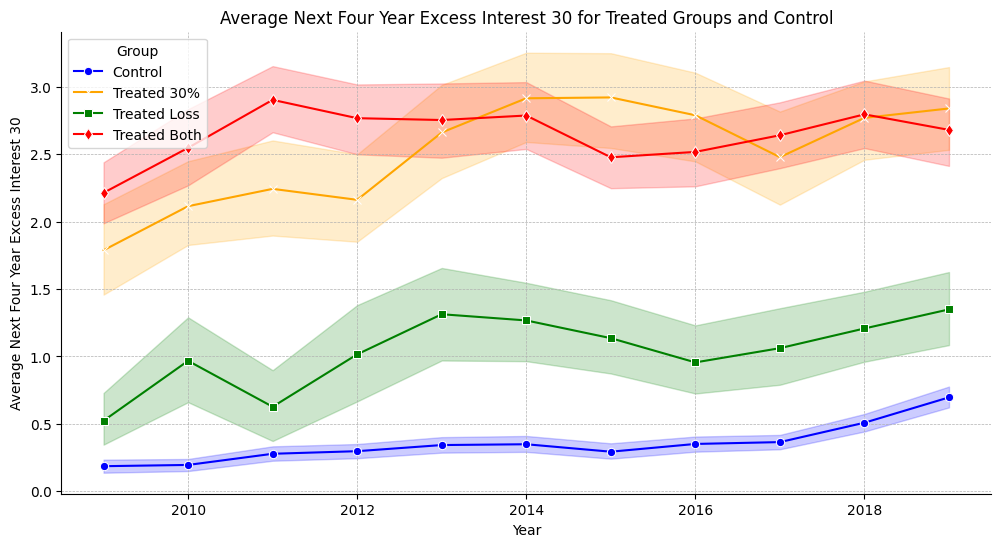

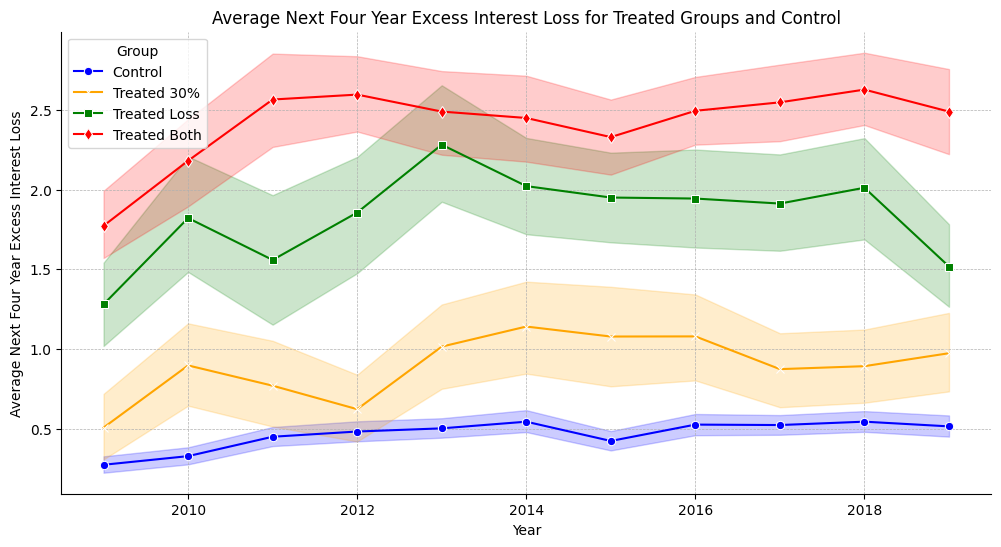

In [388]:
# Merge with gvkey_list
gvkey_list = pd.DataFrame(gvkey_list)
# rename columns to gvkey
gvkey_list.columns = ['gvkey']

ds_gvkey_treatment_assignment = comp_crspa_merged.merge(pd.DataFrame(gvkey_list), on='gvkey')
# drop any duplicates in terms of gvkey and fyear
ds_gvkey_treatment_assignment = ds_gvkey_treatment_assignment.drop_duplicates(subset=['gvkey', 'fyear'])

# Generate treated_one if only excess_interest_30 == 1
ds_gvkey_treatment_assignment['treated_one'] = ((ds_gvkey_treatment_assignment['excess_interest_30'] == 1) & (ds_gvkey_treatment_assignment['excess_interest_loss'] == 0)).astype(int)

# Generate treated_two if only excess_interest_loss == 1
ds_gvkey_treatment_assignment['treated_two'] = ((ds_gvkey_treatment_assignment['excess_interest_loss'] == 1) & (ds_gvkey_treatment_assignment['excess_interest_30'] == 0)).astype(int)

# Generate treated_three if both excess_interest_30 == 1 and excess_interest_loss == 1
ds_gvkey_treatment_assignment['treated_three'] = ((ds_gvkey_treatment_assignment['excess_interest_30'] == 1) & (ds_gvkey_treatment_assignment['excess_interest_loss'] == 1)).astype(int)

# Generate control if neither excess_interest_30 == 1 nor excess_interest_loss == 1
ds_gvkey_treatment_assignment['control'] = ((ds_gvkey_treatment_assignment['excess_interest_30'] == 0) & (ds_gvkey_treatment_assignment['excess_interest_loss'] == 0)).astype(int)

# generate next_five_year_excess_interest_30 and next_five_year_excess_interest_loss which are sum of excess_interest_30 and excess_interest_loss in the next 5 years
ds_gvkey_treatment_assignment['next_four_year_excess_interest_30'] = ds_gvkey_treatment_assignment.groupby('gvkey')['excess_interest_30'].shift(-1) + ds_gvkey_treatment_assignment.groupby('gvkey')['excess_interest_30'].shift(-2) + ds_gvkey_treatment_assignment.groupby('gvkey')['excess_interest_30'].shift(-3) + ds_gvkey_treatment_assignment.groupby('gvkey')['excess_interest_30'].shift(-4) 
ds_gvkey_treatment_assignment['next_four_year_excess_interest_loss'] = ds_gvkey_treatment_assignment.groupby('gvkey')['excess_interest_loss'].shift(-1) + ds_gvkey_treatment_assignment.groupby('gvkey')['excess_interest_loss'].shift(-2) + ds_gvkey_treatment_assignment.groupby('gvkey')['excess_interest_loss'].shift(-3) + ds_gvkey_treatment_assignment.groupby('gvkey')['excess_interest_loss'].shift(-4)

# generate next_year which is the sum of interest_expense_total_excess in the next 4 years
ds_gvkey_treatment_assignment['next_year_excess_interest_total'] = ds_gvkey_treatment_assignment.groupby('gvkey')['interest_expense_total_excess'].shift(-1).fillna(0)
ds_gvkey_treatment_assignment['next_year_excess_interest_30'] = ds_gvkey_treatment_assignment.groupby('gvkey')['excess_interest_30'].shift(-1).fillna(0)
ds_gvkey_treatment_assignment['next_year_excess_interest_loss'] = ds_gvkey_treatment_assignment.groupby('gvkey')['excess_interest_loss'].shift(-1).fillna(0)

# scale by total assets
ds_gvkey_treatment_assignment['next_year_excess_interest_total'] = ds_gvkey_treatment_assignment['next_year_excess_interest_total'] / ds_gvkey_treatment_assignment.groupby('gvkey')['xint'].shift(-1)
ds_gvkey_treatment_assignment['next_year_excess_interest_30'] = ds_gvkey_treatment_assignment['next_year_excess_interest_30'] / ds_gvkey_treatment_assignment.groupby('gvkey')['xint'].shift(-1)
ds_gvkey_treatment_assignment['next_year_excess_interest_loss'] = ds_gvkey_treatment_assignment['next_year_excess_interest_loss'] / ds_gvkey_treatment_assignment.groupby('gvkey')['xint'].shift(-1)

# order gvkey fyear next_five_year_excess_interest_30 next_five_year_excess_interest_loss excess_interest_30 excess_interest_loss to be seen in the first columns
ds_gvkey_treatment_assignment = ds_gvkey_treatment_assignment[['gvkey', 'fyear','control', 'treated_one', 'treated_two', 'treated_three', 'next_four_year_excess_interest_30', 'next_four_year_excess_interest_loss', 'excess_interest_30', 'excess_interest_loss'] + [col for col in ds_gvkey_treatment_assignment.columns if col not in ['gvkey', 'fyear', 'control', 'treated_one', 'treated_two', 'treated_three', 'next_four_year_excess_interest_30', 'next_four_year_excess_interest_loss', 'excess_interest_30', 'excess_interest_loss']]]

# Plot the average next_four_year_excess_interest_30 for treated_one, treated_two, treated_three, and control
plt.figure(figsize=(12, 6))
sns.lineplot(data=ds_gvkey_treatment_assignment[ds_gvkey_treatment_assignment['control'] == 1], x='fyear', y='next_four_year_excess_interest_30', label='Control', marker='o', color='blue')
sns.lineplot(data=ds_gvkey_treatment_assignment[ds_gvkey_treatment_assignment['treated_one'] == 1], x='fyear', y='next_four_year_excess_interest_30', label='Treated 30%', marker='x', color='orange')
sns.lineplot(data=ds_gvkey_treatment_assignment[ds_gvkey_treatment_assignment['treated_two'] == 1], x='fyear', y='next_four_year_excess_interest_30', label='Treated Loss', marker='s', color='green')
sns.lineplot(data=ds_gvkey_treatment_assignment[ds_gvkey_treatment_assignment['treated_three'] == 1], x='fyear', y='next_four_year_excess_interest_30', label='Treated Both', marker='d', color='red')
plt.title('Average Next Four Year Excess Interest 30 for Treated Groups and Control')
plt.xlabel('Year')
plt.ylabel('Average Next Four Year Excess Interest 30')
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.legend(title='Group')
plt.savefig(f'{overleaf_dir}/Figures/next_four_year_excess_interest_30_avg_treated_control.png')
plt.show()

# Plot the average next_four_year_excess_interest_loss for treated_one, treated_two, treated_three, and control
plt.figure(figsize=(12, 6))
sns.lineplot(data=ds_gvkey_treatment_assignment[ds_gvkey_treatment_assignment['control'] == 1], x='fyear', y='next_four_year_excess_interest_loss', label='Control', marker='o', color='blue')
sns.lineplot(data=ds_gvkey_treatment_assignment[ds_gvkey_treatment_assignment['treated_one'] == 1], x='fyear', y='next_four_year_excess_interest_loss', label='Treated 30%', marker='x', color='orange')
sns.lineplot(data=ds_gvkey_treatment_assignment[ds_gvkey_treatment_assignment['treated_two'] == 1], x='fyear', y='next_four_year_excess_interest_loss', label='Treated Loss', marker='s', color='green')
sns.lineplot(data=ds_gvkey_treatment_assignment[ds_gvkey_treatment_assignment['treated_three'] == 1], x='fyear', y='next_four_year_excess_interest_loss', label='Treated Both', marker='d', color='red')
plt.title('Average Next Four Year Excess Interest Loss for Treated Groups and Control')
plt.xlabel('Year')
plt.ylabel('Average Next Four Year Excess Interest Loss')
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.legend(title='Group')
plt.savefig(f'{overleaf_dir}/Figures/next_four_year_excess_interest_loss_avg_treated_control.png')
plt.show()


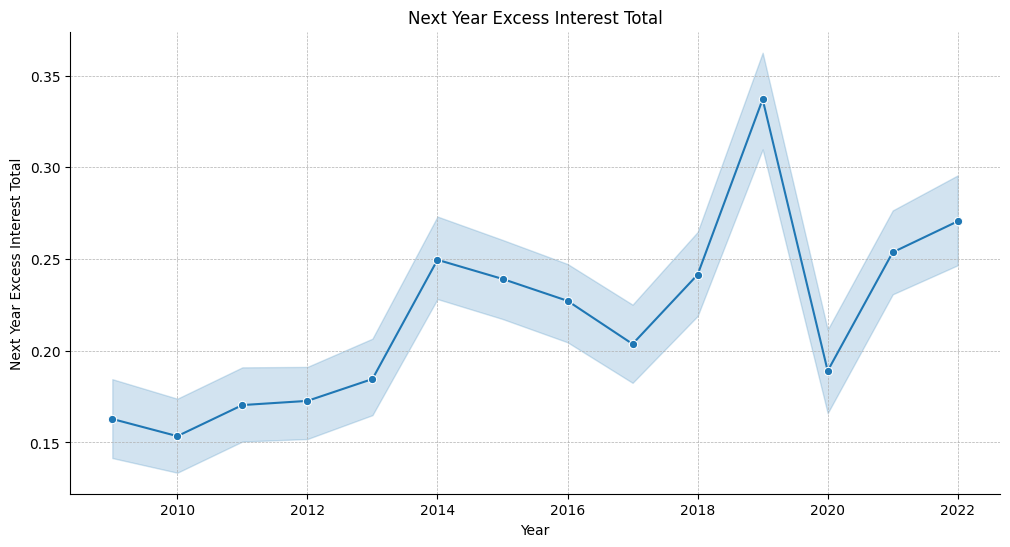

In [389]:
# summarize next_four_year_interest_expense
ds_gvkey_treatment_assignment['next_year_excess_interest_total'].describe()
# plot next_year_excess_interest_total across years
plt.figure(figsize=(12, 6))
sns.lineplot(data=ds_gvkey_treatment_assignment, x='fyear', y='next_year_excess_interest_total', marker='o')
plt.title('Next Year Excess Interest Total')
plt.xlabel('Year')
plt.ylabel('Next Year Excess Interest Total')
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.show()

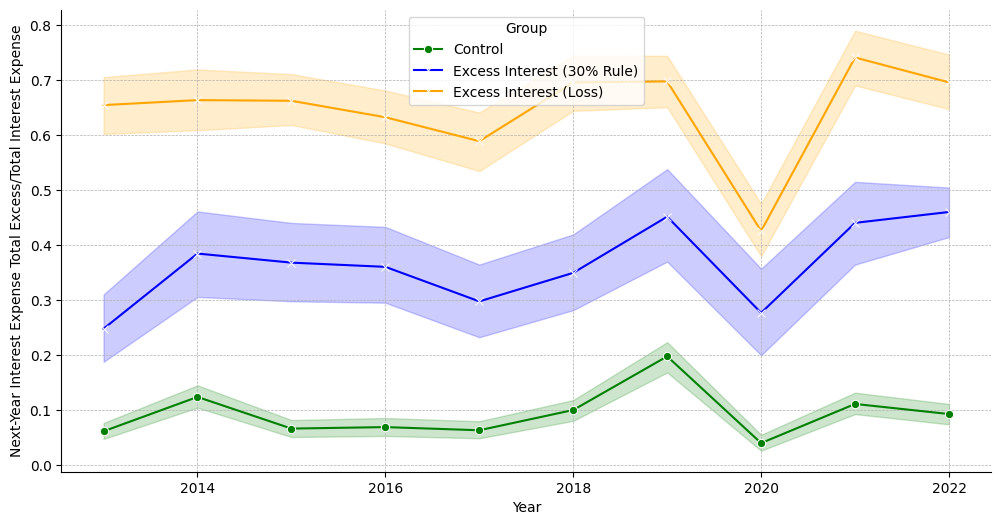

/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_19460/427579927.py:27: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    next_four_year_excess_interest_30   ->   next_four_year_excess_interest_3
    next_four_year_excess_interest_loss   ->   next_four_year_excess_interest_l
    excess_interest_loss_prev_3yr_sum   ->   excess_interest_loss_prev_3yr_su
    excess_interest_loss_prev_5yr_sum   ->   excess_interest_loss_prev_5yr_su
    excess_interest_loss_next_1yr_sum   ->   excess_interest_loss_next_1yr_su
    excess_interest_loss_next_3yr_sum   ->   excess_interest_loss_next_3yr_su
    excess_interest_loss_next_5yr_sum   ->   excess_interest_loss_next_5yr_su
    interest_expense_by_ebitda_next_1yr   ->   interest_expense_by_ebitda_next_

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and un

In [390]:
# generate the upper quartile value of next_four_year_excess_interest_total for each fyear
upper_quartile = ds_gvkey_treatment_assignment.groupby('fyear')['next_year_excess_interest_total'].quantile(0.5).reset_index()
# treated = 1 if next_four_year_excess_interest_total is greater than the upper quartile value and = 0 otherwise
#ds_gvkey_treatment_assignment['treated'] = (ds_gvkey_treatment_assignment['next_year_excess_interest_total'] > ds_gvkey_treatment_assignment['fyear'].map(upper_quartile.set_index('fyear')['next_year_excess_interest_total'])).astype(int)
# treated = 1 if next_four_year_excess_interest_total is greater than 0 and = 0 otherwise
ds_gvkey_treatment_assignment['treated'] = (ds_gvkey_treatment_assignment['next_year_excess_interest_total'] > 0).astype(int)
ds_gvkey_treatment_assignment['treated1'] = (ds_gvkey_treatment_assignment['excess_interest_30'] > 0).astype(int) & (ds_gvkey_treatment_assignment['excess_interest_loss'] == 0)
ds_gvkey_treatment_assignment['treated2'] = (ds_gvkey_treatment_assignment['excess_interest_loss'] > 0).astype(int) & (ds_gvkey_treatment_assignment['excess_interest_30'] == 0)
ds_gvkey_treatment_assignment['treated3'] = (ds_gvkey_treatment_assignment['excess_interest_loss'] > 0).astype(int) & (ds_gvkey_treatment_assignment['excess_interest_30'] > 0)
ds_gvkey_treatment_assignment['control'] = ((ds_gvkey_treatment_assignment['excess_interest_30'] == 0) & (ds_gvkey_treatment_assignment['excess_interest_loss'] == 0)).astype(int)

ds_gvkey_treatment_assignment = ds_gvkey_treatment_assignment[ds_gvkey_treatment_assignment['fyear'] >= 2013]
# plot the interest_expense_total_excess for treated and control over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=ds_gvkey_treatment_assignment[ds_gvkey_treatment_assignment['control'] == 1], x='fyear', y='next_year_excess_interest_total', label='Control', marker='o', color='green')
sns.lineplot(data=ds_gvkey_treatment_assignment[ds_gvkey_treatment_assignment['treated1'] == 1], x='fyear', y='next_year_excess_interest_total', label='Excess Interest (30% Rule)', marker='x', color='blue')
sns.lineplot(data=ds_gvkey_treatment_assignment[ds_gvkey_treatment_assignment['excess_interest_loss'] == 1], x='fyear', y='next_year_excess_interest_total', label='Excess Interest (Loss)', marker='x', color='orange')
plt.xlabel('Year')
plt.ylabel('Next-Year Interest Expense Total Excess/Total Interest Expense')
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
plt.legend(title='Group')
plt.savefig(f'{overleaf_dir}/Figures/interest_expense_total_excess_treated_control.png')
plt.show()

# save a copy of the data including only gvkey fyear treated variable
ds_gvkey_treatment_assignment.to_stata('../3. Data/Processed/ds_gvkey_treatment_assignment.dta', version=117)

In [391]:
# Filter the data for excess_interest_loss == 1 firms after 2018
filtered_data = ds_gvkey_treatment_assignment[(ds_gvkey_treatment_assignment['excess_interest_loss'] == 1) & (ds_gvkey_treatment_assignment['fyear'] >= 2018)]

# Calculate the average next_year_excess_interest_total
average_next_year_excess_interest_total = filtered_data['next_year_excess_interest_total'].mean()

print("Average next_year_excess_interest_total for excess_interest_loss == 1 firms after 2018:", average_next_year_excess_interest_total)

Average next_year_excess_interest_total for excess_interest_loss == 1 firms after 2018: 0.6242659111116531
